## <a name="table">Table of Contents</a> 
1. [Pre-Process Data](#PreProcess)  

2. [Use Case A:Clustering traits and characteristics of international players](#UseCaseA)  
    2.1 [Feature Selection](#UseCaseAFeatureSelection) <br />
    2.2 [Clusters Understanding](#UseCaseAClusterUnderstanding) <br />
    2.3 [Silhoutte Results](#UseCaseASilhoutteResults) <br />
    2.4 [Visualization of clusters for use case A](#UseCaseAVisualization)<br />
    2.5 [Experiment: Time To Load Cluster Visualizations](#UseCaseATimeExperiment)<br />
     
     
3. [Use Case B: Clustering information about players in Premier League and La Liga ](#UseCaseB)  
    3.1 [Feature Selection](#UseCaseBFeatureSelection)<br />
    3.2 [Clusters Understanding](#UseCaseBClusterUnderstanding)<br />
    3.3 [Silhoutte Results](#UseCaseBSilhoutteResults)<br />
    3.4 [Visualization of clusters for use case B](#UseCaseBVisualization)<br />
    3.5 [Experiment: Time To Load Cluster Visualizations](#UseCaseBTimeExperiment)<br />

    

4. [Use Case C: Clustering Information about Football Positions](#UseCaseC)  
    4.1 [Feature Selection](#UseCaseCFeatureSelection)<br />
    4.2 [Clusters Understanding](#UseCaseCClusterUnderstanding)<br />
    4.3 [Silhoutte Results](#UseCaseCSilhoutteResults)<br />
    4.4 [Visualization of clusters for use case C](#UseCaseCVisualization)<br />
    4.5 [Experiment: Time To Load Cluster Visualizations](#UseCaseCTimeExperiment)<br />

## <a name="PreProcess"> 1. Pre-Processing Data</a>

In [3]:
# Import packages for clustering, processing data, dimensionality management and visualizing.
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation
from matplotlib.pyplot import figure
from pyclustertend import hopkins
from scipy import stats
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.tree import _tree, DecisionTreeClassifier
import io
import sys
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import folium
from folium import IFrame

In [8]:
football_players_df = pd.read_excel("football_players.xlsx", sheet_name="Sheet1_Football_players")
def getBirthDate(x):
    if x > 1977:
        return x
    else:
        return None

def getHeight(x):
    x = x.replace("m", "")
    x = x.strip()
    x = float(x)
    if x > 100:
        x = x/100
    
    if x > 1.5 and x < 2.2:
        return x
    else:
        return None
    
def getGoals(x):
    if x < 600:
        return x
    else:
        return None
    
def getLongitude(x):
    x = x.replace('[', '')
    x = x.replace(']', '')
    if "," in x:
        x_list = x.split(',')
        return x_list[0] 
    else:
        return x
    
def getLatitude(x):
    x = x.replace('[', '')
    x = x.replace(']', '')
    if "," in x:
        x_list = x.split(',')
        return x_list[0] 
    else:
        return x
    
def getPosition(x):
    x = x.replace('[', '')
    x = x.replace(']', '')
    if "," in x:
        x_list = x.split(',')
        return x_list
    else:
        return [x]
    
def getBirthYear(x):
    if x > 1978:
        return x
    else:
        return None

def addColumnsForClubs(football_players_df):
    dataset_column_length = len(football_players_df.columns)
    clubsIndex = []
    clubs = football_players_df['clubname'].unique()
    for i in range(len(clubs)):
        clubsIndex.append((i+1,clubs[i]))
    for club in clubs:
        football_players_df["Club_"+ club]=football_players_df["clubname"].map(lambda x: club == x)
    football_players_df.iloc[:,dataset_column_length:] = football_players_df.iloc[:,dataset_column_length:].astype(int)
    football_players_df = football_players_df.drop('clubname', 1)
    return football_players_df
    
def addColumnsForLeague(football_players_df):
    dataset_column_length = len(football_players_df.columns)
    leaguesIndex = []
    leagues = ["Premier League","La Liga"]
    for i in range(len(leagues)):
        leaguesIndex.append((i+1,leagues[i]))
    for league in leagues:
        football_players_df["League_"+ league]=football_players_df["league"].map(lambda x: league == x)
    football_players_df.iloc[:,dataset_column_length:] = football_players_df.iloc[:,dataset_column_length:].astype(int)
    football_players_df = football_players_df.drop('league', 1)
    return football_players_df

def addColumnsForPosition(football_players_df):
    dataset_column_length = len(football_players_df.columns)
    football_players_df["positionlabel"] = football_players_df["positionlabel"].apply(getPosition)
    positionsIndex = []
    positions = ["Goalkeeper (association football)","Defender (association football)","Midfielder","Forward (association football)"]
    for i in range(len(positions)):
        positionsIndex.append((i+1,positions[i]))
        
    for position in positions:
        football_players_df["Position_"+ position]=football_players_df["positionlabel"].map(lambda x: position in x)
        
    football_players_df.iloc[:,dataset_column_length:] = football_players_df.iloc[:,dataset_column_length:].astype(int)
    football_players_df = football_players_df.drop('positionlabel', 1)
    return football_players_df

def addColumnsForNumClubs(football_players_df):
    football_players_df = football_players_df[pd.to_numeric(football_players_df['num_clubs'], errors='coerce').notnull()]
    return football_players_df

def addColumnsForBirthDate(football_players_df):
    football_players_df["birthDate"] = football_players_df["birthDate"].apply(getBirthYear)
    football_players_df = football_players_df[pd.to_numeric(football_players_df['birthDate'], errors='coerce').notnull()]
    return football_players_df

def addColumnsForHeight(football_players_df): 
    football_players_df["height"] = football_players_df["height"].apply(getHeight)
    football_players_df = football_players_df[pd.to_numeric(football_players_df['height'], errors='coerce').notnull()]
    return football_players_df

def addColumnsForNationalCaps(football_players_df):
    football_players_df = football_players_df[pd.to_numeric(football_players_df['nationalcaps'], errors='coerce').notnull()]
    return football_players_df
    
def addColumnsForNationalGoals(football_players_df):
    football_players_df = football_players_df[pd.to_numeric(football_players_df['nationalgoals'], errors='coerce').notnull()]
    return football_players_df

def addColumnsForGoals(football_players_df): 
    football_players_df["goals"] = football_players_df["goals"].apply(getGoals)
    football_players_df = football_players_df[pd.to_numeric(football_players_df['goals'], errors='coerce').notnull()]
    return football_players_df

def addColumnsForClubCaps(football_players_df):
    football_players_df = football_players_df[pd.to_numeric(football_players_df['clubcaps'], errors='coerce').notnull()]
    return football_players_df

def addColumnsForLatitude(football_players_df):
    football_players_df["latitude"] = football_players_df["latitude"].apply(getLatitude)
    return football_players_df

def addColumnsForLongitude(football_players_df):
    football_players_df["longitude"] = football_players_df["longitude"].apply(getLongitude)
    return football_players_df

def edit_data_frame_with_columns(lst_of_features,football_players_df):
    football_players_df = football_players_df.drop('birthPlace', 1)
    football_players_df.drop_duplicates(subset ='name', keep = False, inplace = True)
    if 'name' not in lst_of_features:
        football_players_df = football_players_df.drop('name', 1)
    if 'longitude' in lst_of_features:
        football_players_df = addColumnsForLongitude(football_players_df)
    else:
        football_players_df = football_players_df.drop('longitude', 1)
    if 'latitude' in lst_of_features:
        football_players_df = addColumnsForLatitude(football_players_df)
    else:
        football_players_df = football_players_df.drop('latitude', 1)
    if 'clubname' not in lst_of_features:
        football_players_df = football_players_df.drop('clubname', 1)
    if 'league' in lst_of_features:  
        football_players_df = addColumnsForLeague(football_players_df)
    else:
        football_players_df = football_players_df.drop('league', 1)
    if 'positionlabel' in lst_of_features:  
        football_players_df = addColumnsForPosition(football_players_df)
    else:    
        football_players_df = football_players_df.drop('positionlabel', 1)
    if 'num_clubs' in lst_of_features:
        football_players_df = addColumnsForNumClubs(football_players_df)
    else:   
        football_players_df = football_players_df.drop('num_clubs', 1) 
    if 'birthDate' in lst_of_features:
        football_players_df = addColumnsForBirthDate(football_players_df)
    else:   
        football_players_df = football_players_df.drop('birthDate',1)
    if 'height' in lst_of_features:
        football_players_df = addColumnsForHeight(football_players_df) 
    else:   
        football_players_df = football_players_df.drop('height', 1) 
    if 'nationalgoals' in lst_of_features:
        football_players_df = addColumnsForNationalGoals(football_players_df) 
    else:   
        football_players_df = football_players_df.drop('nationalgoals', 1)
    if 'nationalcaps' in lst_of_features:
        football_players_df = addColumnsForNationalCaps(football_players_df) 
    else:   
        football_players_df = football_players_df.drop('nationalcaps', 1) 
    if 'goals' in lst_of_features:
        football_players_df = addColumnsForGoals(football_players_df) 
    else:   
        football_players_df = football_players_df.drop('goals', 1)
    if 'clubcaps' in lst_of_features:
        football_players_df = addColumnsForClubCaps(football_players_df) 
    else:   
        football_players_df = football_players_df.drop('clubcaps', 1) 
    for column in  football_players_df:
        true_value_per_column = football_players_df.loc[(football_players_df[column] == 0.0)]
        if len(true_value_per_column)+1 >= len(football_players_df):
            football_players_df = football_players_df.drop(column, 1)
    return football_players_df

def find_largest_silhoutte_score_for_features(lst_of_features,football_players_df,cosine_distance):
    football_players_df = edit_data_frame_with_columns(lst_of_features,football_players_df)
    scaler = MinMaxScaler()
    data_scaled = pd.DataFrame(scaler.fit_transform(football_players_df), columns=football_players_df.columns)
    data_scaled.head()
    distance_metric = 'euclidean'
    linkage_types = ['ward','average','complete']
    if cosine_distance == True:
        distance_metric = 'cosine'
        linkage_types = ['average','complete','single']
    max_clusters = 0
    if len(football_players_df.index) > 17:
        max_clusters = 17
    else:
        max_clusters = int(len(football_players_df.index)/2)
    silhoutte_scores = []
    for link in linkage_types:
        for i in range(2,max_clusters):
            cluster = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage=link) 
            model = cluster.fit_predict(data_scaled)
            hierarchical_clustering = pd.DataFrame(model)
            silhoutte_scores.append((link,i,silhouette_score(data_scaled,hierarchical_clustering[0],metric='euclidean')))
    silhoutte_scores.sort(key=lambda x:x[2]) #Order elements by the Silhoutte Score
    return silhoutte_scores[-1]

def find_best_features(lst,num_features,football_players_df,cosine_distance):
    largest_element = None
    players_df = football_players_df.copy()
    i = 0
    current_elements = []
    optimal_num_cluster = 0
    optimal_link_type = ""
    while i < num_features:
        max_shil_score = 0
        largest_element = 0
        for items in lst:
            test_players_df = players_df.copy()
            new_lst = current_elements + [items]
            link, num_clusters ,score = find_largest_silhoutte_score_for_features(new_lst,test_players_df,cosine_distance)
            if score > max_shil_score:
                largest_element = items
                max_shil_score = score
                optimal_num_cluster = num_clusters
                optimal_link_type = link
        current_elements.append(largest_element)
        lst.remove(largest_element)
        i += 1
    return ((current_elements,optimal_link_type, optimal_num_cluster,max_shil_score))


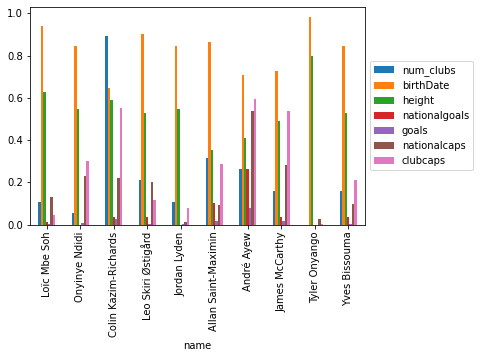

In [9]:
football_players_df["height"] = football_players_df["height"].apply(getHeight)
football_players_df_copy = football_players_df.copy()
scaler = MinMaxScaler()
football_players_id = football_players_df_copy.iloc[0:10,0]
football_players_df_copy = football_players_df_copy.drop('clubname', 1)
football_players_df_copy = football_players_df_copy.drop('league', 1)
football_players_df_copy = football_players_df_copy.drop('longitude', 1)
football_players_df_copy = football_players_df_copy.drop('latitude', 1)
football_players_df_copy = football_players_df_copy.drop('birthPlace', 1)
football_players_df_copy = football_players_df_copy.drop('positionlabel', 1)
football_players_df_copy = football_players_df_copy.drop('name', 1)
football_playersColumns = football_players_df_copy.columns
football_players_categories_df = pd.DataFrame(scaler.fit_transform(football_players_df_copy))
football_players_categories_df.columns = football_playersColumns
football_players_categories_df = football_players_categories_df.iloc[0:10,:]
football_players_categories_df["name"] = football_players_id.values
plot1 = football_players_categories_df.plot.bar(x = "name")
plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig1 = plot1.get_figure()
fig1.savefig('FootballPlayerData1.png', dpi=300, bbox_inches='tight')

## <a name="UseCaseA">2. Use Case A: Clustering traits and characteristics of international players  </a>

### <a name="UseCaseAFeatureSelection">2.1. FeatureSelection</a> 
[Back to Table of Contents](#table)

In [10]:
football_players_df = pd.read_excel("football_players.xlsx", sheet_name="Sheet1_Football_players")
print(find_best_features(['num_clubs','birthDate','height','nationalgoals','nationalcaps','goals','clubcaps'],4,football_players_df,False))


(['num_clubs', 'goals', 'nationalcaps', 'nationalgoals'], 'average', 2, 0.7855464112670882)


In [11]:
football_players_df = pd.read_excel("football_players.xlsx", sheet_name="Sheet1_Football_players")
football_players_df = edit_data_frame_with_columns(['num_clubs', 'goals', 'nationalgoals', 'nationalcaps'],football_players_df)
football_players_df = football_players_df.drop(labels=[573], axis=0)#Removing outlier
df1_football_players = football_players_df
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(football_players_df), columns=football_players_df.columns)
data_scaled.head()

num_clubs  nationalgoals     goals  nationalcaps
0   0.105263       0.015385  0.003086      0.128866
1   0.052632       0.000000  0.033951      0.231959
2   0.894737       0.046154  0.123457      0.221649
3   0.210526       0.046154  0.009259      0.201031
4   0.105263       0.000000  0.003086      0.010309

##### Identifying and removing outliers

In [12]:
data_scaled[(np.abs(stats.zscore(data_scaled)) < 3).all(axis=1)]

num_clubs  nationalgoals     goals  nationalcaps
0     0.105263       0.015385  0.003086      0.128866
1     0.052632       0.000000  0.033951      0.231959
3     0.210526       0.046154  0.009259      0.201031
4     0.105263       0.000000  0.003086      0.010309
5     0.315789       0.138462  0.080247      0.092784
..         ...            ...       ...           ...
915   0.263158       0.015385  0.033951      0.061856
916   0.210526       0.092308  0.018519      0.118557
917   0.263158       0.000000  0.000000      0.025773
918   0.315789       0.000000  0.015432      0.103093
921   0.263158       0.000000  0.070988      0.025773

[862 rows x 4 columns]

##### Testing to determine the clustering tendency of a data set.

In [13]:
hopkins(df1_football_players,len(df1_football_players))

0.12062194014126562

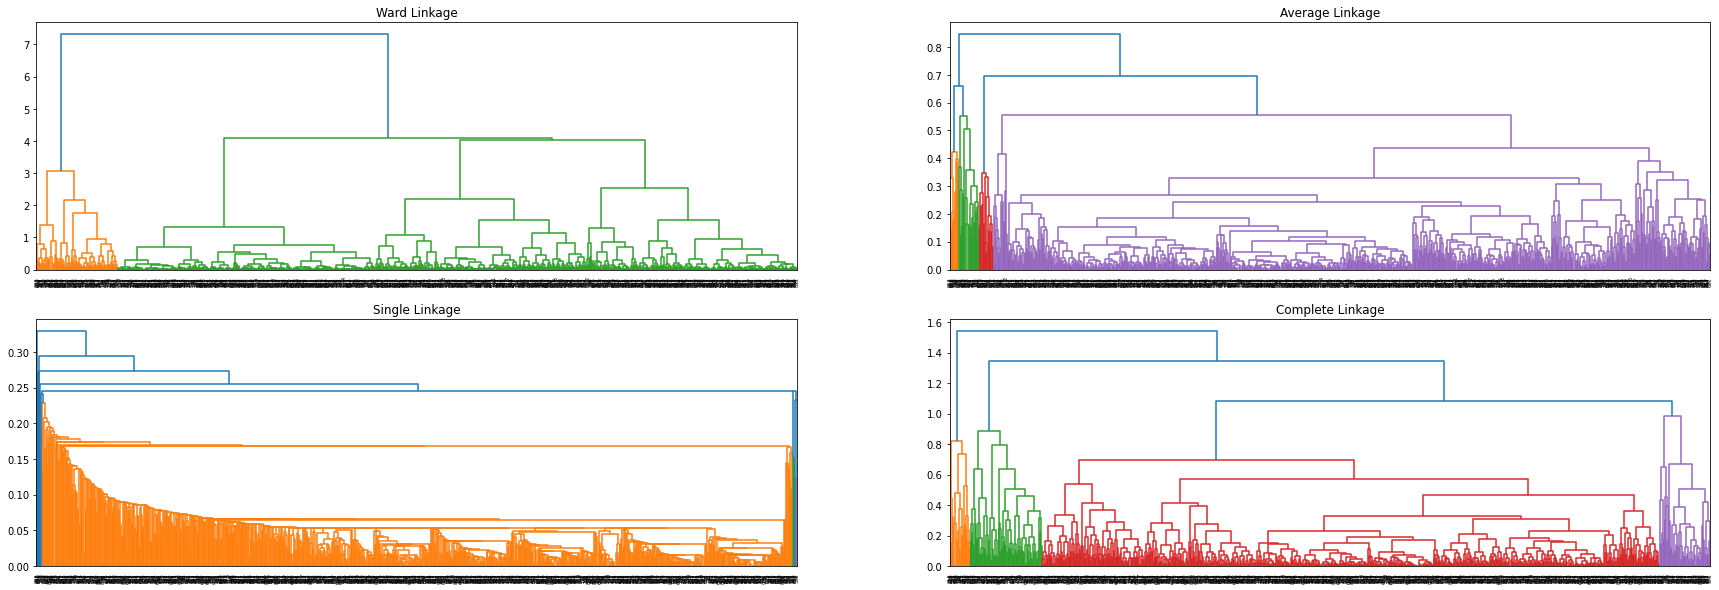

In [14]:
import scipy.cluster.hierarchy as shc
rows = 2
columns = 2
figure = plt.figure(figsize=(30, 10))  
figure.add_subplot(rows, columns, 1)
plt.title("Ward Linkage")  
shc.dendrogram(shc.linkage(data_scaled, method='ward'))
figure.add_subplot(rows, columns, 2)
plt.title("Average Linkage")  
shc.dendrogram(shc.linkage(data_scaled, method='average'))
figure.add_subplot(rows, columns, 3)
plt.title("Single Linkage")  
shc.dendrogram(shc.linkage(data_scaled, method='single'))
figure.add_subplot(rows, columns, 4)
plt.title("Complete Linkage")  
shc.dendrogram(shc.linkage(data_scaled, method='complete'))
figure.savefig('DendogramsFotoPlayA1.png', dpi=300, bbox_inches='tight')


## Applying Hierarchical clustering for the clusters

In [15]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='average')  
team_models = cluster.fit_predict(data_scaled)

### <a name="UseCaseAClusterUnderstanding">2.2 Feature Selection and Understanding Clusters</a> 
[Back to Table of Contents](#table)

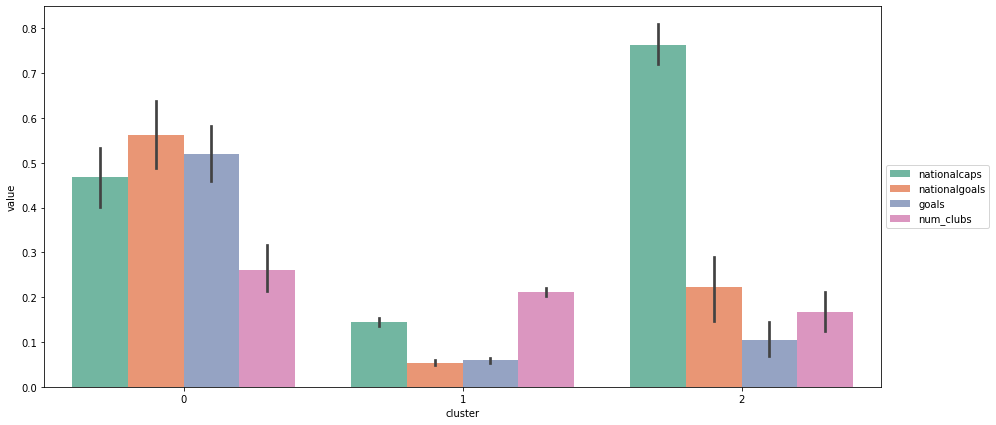

In [16]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='average')  
team_models = cluster.fit_predict(data_scaled)
minMaxscaler = MinMaxScaler()
scaledDataFrame = pd.DataFrame(minMaxscaler.fit_transform(df1_football_players))
scaledDataFrame.columns = df1_football_players.columns
scaledDataFrame['cluster'] = cluster.labels_
# Largest standard deviation likely to have largest importance
meansDataFrame = scaledDataFrame.groupby('cluster').mean().reset_index()
variablesDeviations = pd.DataFrame(columns=['Vars', 'Deviation'])
i = 0
while i < len(meansDataFrame.columns[1:]):
    variablesDeviations.loc[len(variablesDeviations), :] = [meansDataFrame.columns[1:][i], np.std(meansDataFrame[meansDataFrame.columns[1:][i]])]
    i+=1
includedColumns = list(variablesDeviations.sort_values('Deviation', ascending=False).head(4).Vars.values) + ['cluster']
finalData = scaledDataFrame[includedColumns].melt(id_vars='cluster')
figure, axix = plt.subplots(figsize=(15, 7))
sns.barplot(x='cluster', y='value', hue='variable', data=finalData, palette='Set2')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("clustersFromFootPlayersA.jpg", dpi=300)

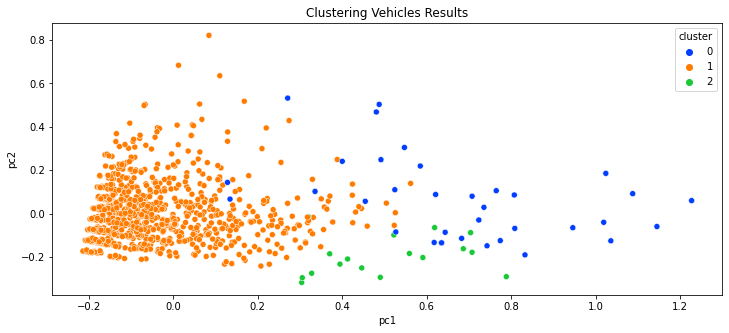

In [17]:
from sklearn.decomposition import PCA
fig, (sub1) = plt.subplots(1, figsize=(12, 5))
pca_vehicle_data = PCA(n_components=2)
principalComponents_vehicles = pca_vehicle_data.fit_transform(data_scaled)
sns.scatterplot(x=principalComponents_vehicles[:,0], y=principalComponents_vehicles[:,1], hue=team_models, palette='bright',ax=sub1);
sub1.set(xlabel="pc1", ylabel="pc2", title="Clustering Vehicles Results")
sub1.legend(title='cluster');
fig.savefig('PCAFootPlayersA1.png', dpi=300, bbox_inches='tight')

##### Creating Clusters Rule Table

In [18]:
dct_of_clusters = {"cluster numbers":[1,2,3],"cluster descriptions": ["The majority of players in this cluster have scored more than 119.5 goals", 
                                            "The majority of players in this cluster have scored less than 119.5 goals and have less than 121 national caps",
                                            "The majority of players in this cluster have scored less than 119.5 goals and have more than 121 national caps"]
}

df_of_results = pd.DataFrame(dct_of_clusters)  
print(df_of_results.to_latex())


   

\begin{tabular}{lrl}
\toprule
{} &  cluster numbers &                               cluster descriptions \\
\midrule
0 &                1 &  The majority of players in this cluster have s... \\
1 &                2 &  The majority of players in this cluster have s... \\
2 &                3 &  The majority of players in this cluster have s... \\
\bottomrule
\end{tabular}



### <a name="UseCaseASilhoutteResults">2.3 Analysing Cluster Results with Different linkage criteria and number of clusters</a> 
[Back to Table of Contents](#table)

In [19]:
sil_scores = []
dav_scores = []
calin_scores = []
n_clusters = []
for i in range(2,20):
    cluster1 = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='average')  
    team_models1 = cluster1.fit_predict(data_scaled)
    hierarchical_clustering = pd.DataFrame(team_models1)
    dav_scores.append(davies_bouldin_score(data_scaled,hierarchical_clustering[0]))
    sil_scores.append(silhouette_score(data_scaled,hierarchical_clustering[0],metric='euclidean'))
    calin_scores.append(calinski_harabasz_score(data_scaled,hierarchical_clustering[0]))
    n_clusters.append(i)
    
hierarchicial_clustering_results_df = {'Num Clusters': n_clusters,'Silhouette Score': sil_scores, 'Davies Bouldin Score': dav_scores,'Calinski Harabasz Score': calin_scores}  
df_measures = pd.DataFrame(hierarchicial_clustering_results_df)  
print(df_measures.to_latex())


\begin{tabular}{lrrrr}
\toprule
{} &  Num Clusters &  Silhouette Score &  Davies Bouldin Score &  Calinski Harabasz Score \\
\midrule
0  &             2 &          0.623187 &              0.761926 &               312.625264 \\
1  &             3 &          0.551064 &              0.850615 &               240.115175 \\
2  &             4 &          0.517494 &              0.855183 &               182.583499 \\
3  &             5 &          0.446999 &              0.871450 &               170.469726 \\
4  &             6 &          0.445925 &              0.853185 &               142.768830 \\
5  &             7 &          0.444898 &              0.824244 &               121.146346 \\
6  &             8 &          0.395093 &              0.943020 &               177.082200 \\
7  &             9 &          0.392672 &              0.986977 &               157.187503 \\
8  &            10 &          0.378347 &              0.960937 &               142.076973 \\
9  &            11 &         

In [20]:
cluster1 = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
team_models1 = cluster1.fit_predict(data_scaled)
hierarchical_clustering1 = pd.DataFrame(team_models1)
davies_bouldin_score1 = davies_bouldin_score(data_scaled,hierarchical_clustering1[0])
silhouette_score1 = silhouette_score(data_scaled,hierarchical_clustering1[0],metric='euclidean')
calinski_harabasz_score1 = calinski_harabasz_score(data_scaled,hierarchical_clustering1[0])

cluster2 = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='average')  
team_models2 = cluster2.fit_predict(data_scaled)
hierarchical_clustering2 = pd.DataFrame(team_models2)
davies_bouldin_score2 = davies_bouldin_score(data_scaled,hierarchical_clustering2[0])
silhouette_score2 = silhouette_score(data_scaled,hierarchical_clustering2[0],metric='euclidean')
calinski_harabasz_score2 = calinski_harabasz_score(data_scaled,hierarchical_clustering2[0])

cluster3 = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')  
team_models3 = cluster3.fit_predict(data_scaled)
hierarchical_clustering3 = pd.DataFrame(team_models3)
davies_bouldin_score3 = davies_bouldin_score(data_scaled,hierarchical_clustering3[0])
silhouette_score3 = silhouette_score(data_scaled,hierarchical_clustering3[0],metric='euclidean')
calinski_harabasz_score3 = calinski_harabasz_score(data_scaled,hierarchical_clustering3[0])

cluster4 = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='single') 
team_models4 = cluster4.fit_predict(data_scaled)
hierarchical_clustering4 = pd.DataFrame(team_models4)
davies_bouldin_score4 = davies_bouldin_score(data_scaled,hierarchical_clustering4[0])
silhouette_score4 = silhouette_score(data_scaled,hierarchical_clustering4[0],metric='euclidean')
calinski_harabasz_score4 = calinski_harabasz_score(data_scaled,hierarchical_clustering4[0])

hierarchicial_clustering_results_df = {'Linkage Type': ['Ward','Average','Complete','Single'],'Silhouette Score': [silhouette_score1,silhouette_score2,silhouette_score3,silhouette_score4], 'Davies Bouldin Score': [davies_bouldin_score1, davies_bouldin_score2, davies_bouldin_score3, davies_bouldin_score4],'Calinski Harabasz Score': [calinski_harabasz_score1, calinski_harabasz_score2, calinski_harabasz_score3, calinski_harabasz_score4]}  
df_measures = pd.DataFrame(hierarchicial_clustering_results_df)  
print(df_measures.to_latex())

\begin{tabular}{llrrr}
\toprule
{} & Linkage Type &  Silhouette Score &  Davies Bouldin Score &  Calinski Harabasz Score \\
\midrule
0 &         Ward &          0.201930 &              1.268782 &               385.784549 \\
1 &      Average &          0.551064 &              0.850615 &               240.115175 \\
2 &     Complete &          0.439304 &              1.035816 &               307.985482 \\
3 &       Single &          0.667679 &              0.295206 &                23.290485 \\
\bottomrule
\end{tabular}



#### Determining the number of clusters for K-means Algorithm using Silhouette Visualizer

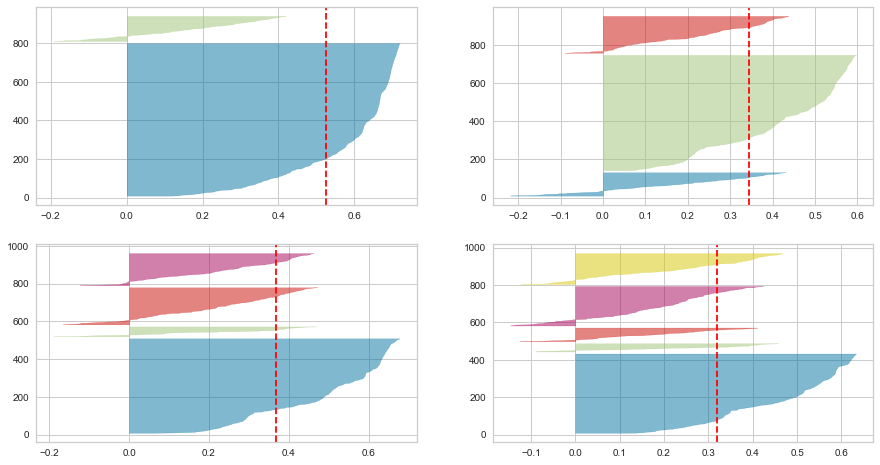

In [21]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data_scaled)

#### Criteria for DBSCAN

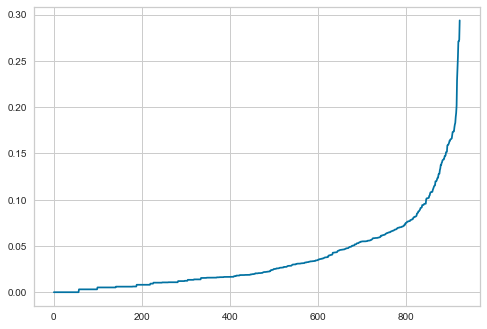

In [22]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(data_scaled)
distances, indices = nbrs.kneighbors(data_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

#### Comparing the cell types

In [23]:
kmeans_norm = KMeans(n_clusters=4).fit(data_scaled)
dbs_data = DBSCAN(eps=0.02, min_samples=2).fit(data_scaled)

silhouette_score1 = silhouette_score(data_scaled, hierarchical_clustering2[0],metric='euclidean')
silhouette_score2 = silhouette_score(data_scaled, kmeans_norm.labels_, metric='euclidean')
silhouette_score3 = silhouette_score(data_scaled, kmeans_norm.labels_, metric='cosine')
silhouette_score4 = silhouette_score(data_scaled, dbs_data.labels_)

davies_bouldin_score1 = davies_bouldin_score(data_scaled,hierarchical_clustering2[0])
davies_bouldin_score2 = davies_bouldin_score(data_scaled,kmeans_norm.labels_)
davies_bouldin_score3 = davies_bouldin_score(data_scaled,kmeans_norm.labels_)
davies_bouldin_score4 = davies_bouldin_score(data_scaled,dbs_data.labels_)

calinski_harabasz_score1 = calinski_harabasz_score(data_scaled,hierarchical_clustering2[0])
calinski_harabasz_score2 = calinski_harabasz_score(data_scaled,kmeans_norm.labels_)
calinski_harabasz_score3 = calinski_harabasz_score(data_scaled,kmeans_norm.labels_)
calinski_harabasz_score4 = calinski_harabasz_score(data_scaled,dbs_data.labels_)

clustering_results_df = {'Linkage Type': ['Agglomerative Hierarchical clustering(linkage = Average)','Kmeans','Cosine Based Kmeans','DBSCAN'],'Silhouette Score': [silhouette_score1,silhouette_score2,silhouette_score3,silhouette_score4], 'Davies Bouldin Score': [davies_bouldin_score1, davies_bouldin_score2, davies_bouldin_score3, davies_bouldin_score4],'Calinski Harabasz Score': [calinski_harabasz_score1, calinski_harabasz_score2, calinski_harabasz_score3, calinski_harabasz_score4]}  
df_of_results = pd.DataFrame(clustering_results_df)  
print(df_of_results.to_latex())

\begin{tabular}{llrrr}
\toprule
{} &                                       Linkage Type &  Silhouette Score &  Davies Bouldin Score &  Calinski Harabasz Score \\
\midrule
0 &  Agglomerative Hierarchical clustering(linkage ... &          0.551064 &              0.850615 &               240.115175 \\
1 &                                             Kmeans &          0.366874 &              0.996494 &               501.882525 \\
2 &                                Cosine Based Kmeans &         -0.066106 &              0.996494 &               501.882525 \\
3 &                                             DBSCAN &         -0.130737 &              1.217823 &                 5.549179 \\
\bottomrule
\end{tabular}



### <a name="UseCaseAVisualization">2.4 Visualization of clusters for use case A</a> 
[Back to Table of Contents](#table)



In [24]:
import io
import sys
import folium
from PyQt5 import QtCore, QtGui, QtWidgets
from PyQt5.QtWebEngineWidgets import QWebEngineView 
from PyQt5.QtWebEngineWidgets import QWebEngineSettings as QWebSettings
from folium import IFrame
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import collections, numpy
from matplotlib import animation
from pyclustertend import hopkins
from scipy import stats
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import folium
class Window(QtWidgets.QMainWindow):
    def __init__(self,dataset):
        self._dataset = dataset
        self._df_including_cordinates = self._dataset.copy()
        self._dataset.drop('longitude', inplace=True, axis=1)
        self._dataset.drop('latitude', inplace=True, axis=1)
        self._dataset.drop('name', inplace=True, axis=1)
        super().__init__()
        self.initWindow()

    def initWindow(self):
        self.setWindowTitle(self.tr("Football Player Clusters"))
        self.setFixedSize(1500, 800)
        self.editField1 = QtWidgets.QLineEdit(self)
        self.editField2 = QtWidgets.QLineEdit(self)
        self.editField3 = QtWidgets.QLineEdit(self)
        self.editField4 = QtWidgets.QLineEdit(self)
        self.label5 = QtWidgets.QLabel('red',self)
        self.label5.setHidden(True)
        self.m = folium.Map(location=[51.5074, 0.1278], zoom_start=6)
        self.buttonUI()

    def buttonUI(self):
        submitButton = QtWidgets.QPushButton(self.tr("Submit"))
        submitButton.clicked.connect(self.calculateClusterPressed)
        self.editField1.setFixedSize(120, 50)
        self.editField2.setFixedSize(120, 50)
        self.editField3.setFixedSize(120, 50)
        self.editField4.setFixedSize(120, 50) 
        submitButton.move(20, 260)
        label1 = QtWidgets.QLabel(self)
        label1.setText("Number Of Clubs:")
        label1.setFixedSize(120, 50)
        label2 = QtWidgets.QLabel(self)
        label2.setText("Club Goals:")
        label2.setFixedSize(120, 50)
        label3 = QtWidgets.QLabel(self)
        label3.setText("National Goals:")
        label3.setFixedSize(120, 50)  
        label4 = QtWidgets.QLabel(self)
        label4.setText("National Caps:")
        label4.setFixedSize(120, 50)
        self.label5.setText("Data is an outlier")
        self.label5.setFixedSize(120, 50)
        self.label5.setStyleSheet("background-color: red")
        self.view = QWebEngineView()
        self.view.setContentsMargins(50, 50, 50, 50)
        central_widget = QtWidgets.QWidget()
        self.setCentralWidget(central_widget)
        lay = QtWidgets.QHBoxLayout(central_widget)
        button_container = QtWidgets.QWidget()
        vlay = QtWidgets.QVBoxLayout(button_container)
        vlay.setSpacing(20)
        vlay.addStretch()
        vlay.addWidget(label1)
        vlay.addWidget(self.editField1)
        vlay.addWidget(label2)
        vlay.addWidget(self.editField2)
        vlay.addWidget(label3)
        vlay.addWidget(self.editField3)
        vlay.addWidget(label4)
        vlay.addWidget(self.editField4)
        vlay.addWidget(submitButton)
        vlay.addWidget(self.label5)
        vlay.addStretch()
        lay.addWidget(button_container)
        lay.addWidget(self.view, stretch=1)
        data = io.BytesIO()
        self.m.save(data, close_file=False)
        self.view.setHtml(data.getvalue().decode())
    
    def calculateClusterPressed(self):
        insertData = {'num_clubs':self.editField1.text(), 'goals':self.editField2.text(),
                       'nationalgoals':self.editField3.text(), 'nationalcaps':self.editField4.text() }
        self._dataset = self._dataset.append(insertData, ignore_index=True)
        df1_football_players = football_players_df
        scaler = MinMaxScaler()
        data_scaled = pd.DataFrame(scaler.fit_transform(self._dataset), columns=self._dataset.columns)
        cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='average')  
        team_models = cluster.fit_predict(data_scaled)
        hierarchical_clustering = pd.DataFrame(team_models)
        dct_of_colour =  {0:"red", 1:"green",2:"blue"}
        new_item_cluster = team_models[-1]
        if np.count_nonzero(team_models == new_item_cluster) == 1:
            self.label5.setHidden(False)            
        else:
            self.label5.setHidden(True)
            i = 0
            for index, row in self._df_including_cordinates.iterrows():
                if hierarchical_clustering[0][i] == team_models[-1]:
                    html="""
                    <h1>""" + str(row['name']) + """'s data'</h1><br>
                    <b> Name: </b> """ + str(row['name']) + """ <br>
                    <b> Number Of Clubs Played For: </b> """ + str(row['num_clubs']) + """ <br>
                    <b> Number Of Club Goals Scored: </b> """ + str(row['goals']) + """ <br>
                    <b> Number Of International Appearances: </b> """ + str(row['nationalcaps']) + """ <br>
                    <b> Number Of International Goals: </b> """ + str(row['nationalgoals']) + """ <br>
                    """

                    frame = IFrame(html=html, width=500, height=300)
                    pop_text = folium.Popup(frame, max_width=2650)
                    folium.Marker(
                    [row['latitude'], row['longitude']], 
                    popup = pop_text, 
                    icon=folium.Icon(color = dct_of_colour[hierarchical_clustering[0][i]], icon="fa-futbol"),
                    ).add_to(self.m)
                i += 1
                self.m
                data = io.BytesIO()
                self.m.save(data, close_file=False)
                self.view.setHtml(data.getvalue().decode())
        
        
if __name__ == "__main__":
    football_players_df = pd.read_excel("football_players.xlsx", sheet_name="Sheet1_Football_players")
    football_players_df = football_players_df.drop(labels=[573], axis=0)
    df1_football_players = edit_data_frame_with_columns(['name','latitude','longitude','num_clubs', 'goals', 'nationalgoals', 'nationalcaps'],football_players_df)
    App = QtCore.QCoreApplication.instance()
    if App is None:
        App = QtWidgets.QApplication(sys.argv)
    window = Window(df1_football_players)
    window.show()
    sys.exit(App.exec())


SystemExit: 0

/Users/colmclery/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)



### <a name="UseCaseATimeExperiment">2.5 Experimenting Time To Load Cluster items</a> 
[Back to Table of Contents](#table)

In [25]:
import time
num_clusters = 3
affin = 'euclidean'
link = 'average'
df1_football_players = pd.read_excel("football_players.xlsx", sheet_name="Sheet1_Football_players")
df1_football_players = edit_data_frame_with_columns(['name','latitude','longitude','num_clubs', 'goals', 'nationalgoals', 'nationalcaps'],df1_football_players)
df1_football_players_copy = df1_football_players.copy()
df1_football_players.drop('longitude', inplace=True, axis=1)
df1_football_players.drop('latitude', inplace=True, axis=1)
df1_football_players.drop('name', inplace=True, axis=1)
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(df1_football_players), columns=df1_football_players.columns)
cluster = AgglomerativeClustering(n_clusters=num_clusters, affinity=affin, linkage=link) 
team_models = cluster.fit_predict(data_scaled)
hierarchical_clustering = pd.DataFrame(team_models)
data_scaled.insert((data_scaled.shape[1]),'agglomerative',hierarchical_clustering)
dct_of_colour =  {0:"red", 1:"green",2:"blue"}    
times_dct = {"Cluster ID":[],"Number Of Vehicles":[],"Time To Load":[],}
m = folium.Map(location=[51.5074, 0.1278], zoom_start=6)
cluster_id = 0
for cluster in range(num_clusters):
    i = 0
    t1 = time.time()
    count_per_cluster = 0
    for index, row in df1_football_players_copy.iterrows():
        if team_models[i] == cluster_id:
            count_per_cluster += 1
            html="""<h1>""" + str(row['name']) + """'s data'</h1><br>
                    <p>
                    
                    </p>
                    <b> Name: </b> """ + str(row['name']) + """ <br>
                    <b> Number Of Clubs Played For: </b> """ + str(row['num_clubs']) + """ <br>
                    <b> Number Of Club Goals Scored: </b> """ + str(row['goals']) + """ <br>
                    <b> Number Of International Appearances: </b> """ + str(row['nationalcaps']) + """ <br>
                    <b> Number Of International Goals: </b> """ + str(row['nationalgoals']) + """ <br>  
            """
            frame = IFrame(html=html, width=500, height=300)
            pop_text = folium.Popup(frame, max_width=2650)
            folium.Marker(
                    [row['latitude'], row['longitude']], 
                    popup = pop_text, 
                    icon=folium.Icon(color = dct_of_colour[hierarchical_clustering[0][i]], icon="fa-futbol"),
                    ).add_to(m)
        i += 1
    t2 = time.time()
    times_dct["Time To Load"].append(t2 - t1)
    cluster_id+=1
    times_dct["Number Of Vehicles"].append(count_per_cluster)
    times_dct["Cluster ID"].append(cluster_id)
df = pd.DataFrame(times_dct)
print(df.to_latex())
data = io.BytesIO()
m.save(data, close_file=False)
m





\begin{tabular}{lrrr}
\toprule
{} &  Cluster ID &  Number Of Vehicles &  Time To Load \\
\midrule
0 &           1 &                  42 &      0.097738 \\
1 &           2 &                   1 &      0.059943 \\
2 &           3 &                 880 &      1.163036 \\
\bottomrule
\end{tabular}



## <a name="UseCaseB">3. Use Case B: Clustering information about players in Premier League and La Liga </a>

### <a name="UseCaseBFeatureSelection">3.1. FeatureSelection</a> 
[Back to Table of Contents](#table)

In [26]:
football_players_df = pd.read_excel("football_players.xlsx", sheet_name="Sheet1_Football_players")
print(find_best_features(['league','birthDate','height','nationalgoals','nationalcaps','goals','clubcaps'],4,football_players_df,False))

(['league', 'goals', 'nationalgoals', 'height'], 'complete', 2, 0.8427079424169809)


In [27]:
football_players_df = pd.read_excel("football_players.xlsx", sheet_name="Sheet1_Football_players")
football_players_df = edit_data_frame_with_columns(['league', 'goals', 'nationalgoals', 'height'],football_players_df)
#Removing the outlier row 569
football_players_df = football_players_df.drop(labels=[573], axis=0)
df1_football_players = football_players_df
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(football_players_df), columns=football_players_df.columns)
data_scaled.head()

height  nationalgoals     goals  League_Premier League  League_La Liga
0  0.627451       0.015385  0.003086                    1.0             0.0
1  0.549020       0.000000  0.033951                    1.0             0.0
2  0.588235       0.046154  0.123457                    1.0             0.0
3  0.529412       0.046154  0.009259                    1.0             0.0
4  0.549020       0.000000  0.003086                    1.0             0.0

##### Identifying and removing outliers

In [28]:
data_scaled[(np.abs(stats.zscore(data_scaled)) < 3).all(axis=1)]

height  nationalgoals     goals  League_Premier League  League_La Liga
0    0.627451       0.015385  0.003086                    1.0             0.0
1    0.549020       0.000000  0.033951                    1.0             0.0
2    0.588235       0.046154  0.123457                    1.0             0.0
3    0.529412       0.046154  0.009259                    1.0             0.0
4    0.549020       0.000000  0.003086                    1.0             0.0
..        ...            ...       ...                    ...             ...
912  0.490196       0.015385  0.033951                    0.0             1.0
913  0.411765       0.092308  0.018519                    0.0             1.0
914  0.725490       0.000000  0.000000                    0.0             1.0
915  0.588235       0.000000  0.015432                    0.0             1.0
918  0.352941       0.000000  0.070988                    0.0             1.0

[879 rows x 5 columns]

##### Testing to determine the clustering tendency of a data set.

In [29]:
hopkins(df1_football_players,len(df1_football_players))

0.07797074915854758

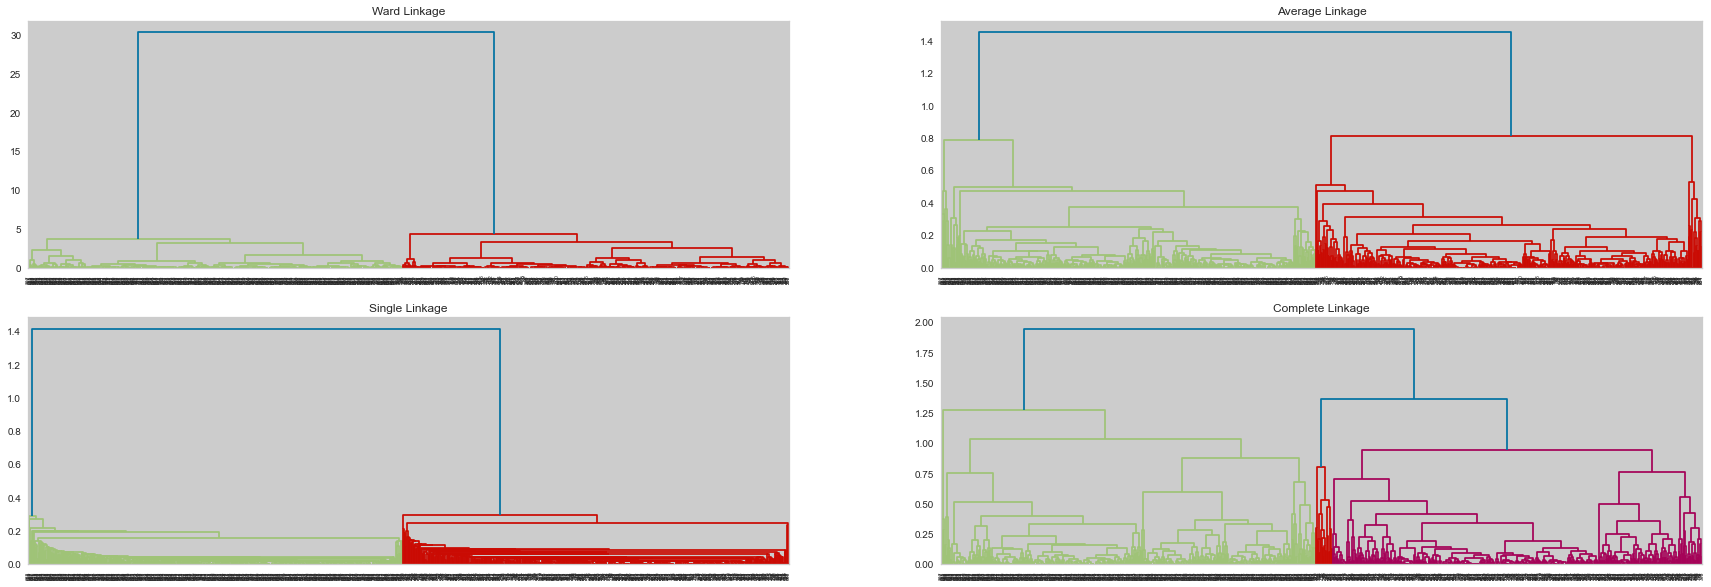

In [30]:
import scipy.cluster.hierarchy as shc
rows = 2
columns = 2
figure = plt.figure(figsize=(30, 10))  
figure.add_subplot(rows, columns, 1)
plt.title("Ward Linkage")  
shc.dendrogram(shc.linkage(data_scaled, method='ward'))
figure.add_subplot(rows, columns, 2)
plt.title("Average Linkage")  
shc.dendrogram(shc.linkage(data_scaled, method='average'))
figure.add_subplot(rows, columns, 3)
plt.title("Single Linkage")  
shc.dendrogram(shc.linkage(data_scaled, method='single'))
figure.add_subplot(rows, columns, 4)
plt.title("Complete Linkage")  
shc.dendrogram(shc.linkage(data_scaled, method='complete'))
figure.savefig('DendogramsFotoPlayB1.png', dpi=300, bbox_inches='tight')


## Applying Hierarchical clustering for the clusters

In [31]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')  
team_models = cluster.fit_predict(data_scaled)


### <a name="UseCaseBClusterUnderstanding">3.2 Feature Selection and Understanding Clusters</a> 
[Back to Table of Contents](#table)

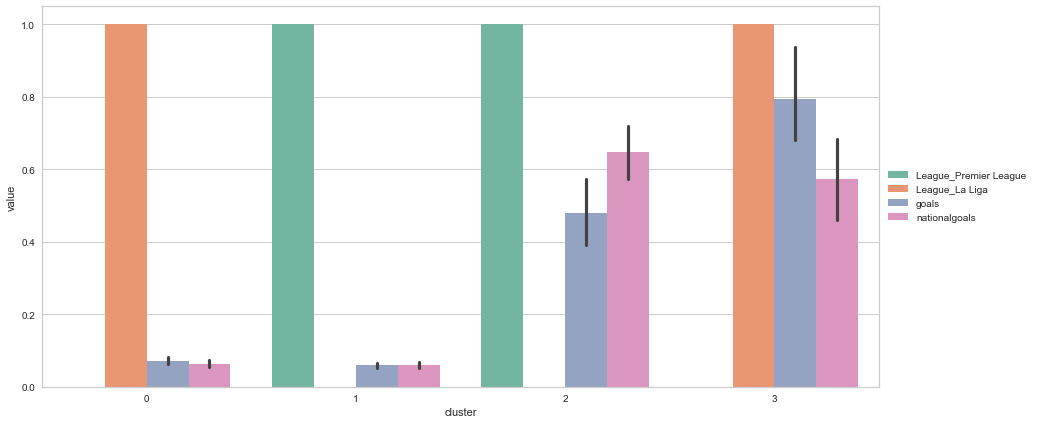

In [32]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')  
team_models = cluster.fit_predict(data_scaled)
minMaxscaler = MinMaxScaler()
scaledDataFrame = pd.DataFrame(minMaxscaler.fit_transform(df1_football_players))
scaledDataFrame.columns = df1_football_players.columns
scaledDataFrame['cluster'] = cluster.labels_
# Largest standard deviation likely to have largest importance
meansDataFrame = scaledDataFrame.groupby('cluster').mean().reset_index()
variablesDeviations = pd.DataFrame(columns=['Vars', 'Deviation'])
i = 0
while i < len(meansDataFrame.columns[1:]):
    variablesDeviations.loc[len(variablesDeviations), :] = [meansDataFrame.columns[1:][i], np.std(meansDataFrame[meansDataFrame.columns[1:][i]])]
    i+=1
    
includedColumns = list(variablesDeviations.sort_values('Deviation', ascending=False).head(4).Vars.values) + ['cluster']
finalData = scaledDataFrame[includedColumns].melt(id_vars='cluster')
figure, axix = plt.subplots(figsize=(15, 7))
sns.barplot(x='cluster', y='value', hue='variable', data=finalData, palette='Set2')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("clustersFromFootPlayersB.jpg", dpi=300)

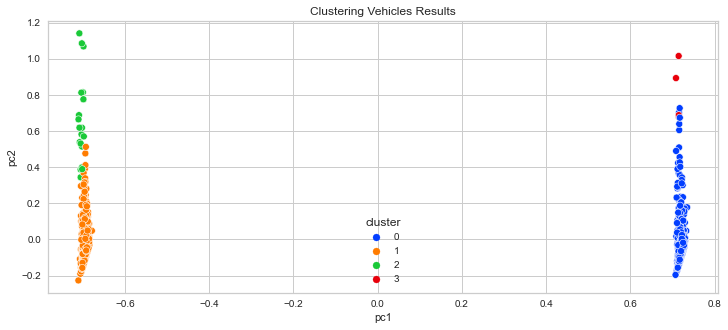

In [33]:
from sklearn.decomposition import PCA
fig, (sub1) = plt.subplots(1, figsize=(12, 5))
pca_vehicle_data = PCA(n_components=2)
principalComponents_vehicles = pca_vehicle_data.fit_transform(data_scaled)
sns.scatterplot(x=principalComponents_vehicles[:,0], y=principalComponents_vehicles[:,1], hue=team_models, palette='bright',ax=sub1);
sub1.set(xlabel="pc1", ylabel="pc2", title="Clustering Vehicles Results")
sub1.legend(title='cluster');
fig.savefig('PCAFootPlayersB1.png', dpi=300, bbox_inches='tight')

##### Creating Clusters Rule Table

In [34]:
dct_of_clusters = {"cluster numbers":[1,2,3,4],"cluster descriptions": ["Play in la liga and have a low amount of club goals and national goals",
                                                "Play in the premier league and have a low amount of club goals and national goals",
                                                "Play in the premier league and have a high amount of club goals and national goals",
                                                "Play in la liga and have a high amount of club goals and national goals"]

}
df_of_results = pd.DataFrame(dct_of_clusters)  
print(df_of_results.to_latex())

\begin{tabular}{lrl}
\toprule
{} &  cluster numbers &                               cluster descriptions \\
\midrule
0 &                1 &  Play in la liga and have a low amount of club ... \\
1 &                2 &  Play in the premier league and have a low amou... \\
2 &                3 &  Play in the premier league and have a high amo... \\
3 &                4 &  Play in la liga and have a high amount of club... \\
\bottomrule
\end{tabular}



### <a name="UseCaseBSilhoutteResults">3.3 Analysing Cluster Results with Different linkage criteria and number of clusters</a> 
[Back to Table of Contents](#table)

In [35]:
sil_scores = []
dav_scores = []
calin_scores = []
n_clusters = []

for i in range(2,20):
    cluster1 = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='complete')  
    team_models1 = cluster1.fit_predict(data_scaled)
    hierarchical_clustering = pd.DataFrame(team_models1)
    dav_scores.append(davies_bouldin_score(data_scaled,hierarchical_clustering[0]))
    sil_scores.append(silhouette_score(data_scaled,hierarchical_clustering[0],metric='euclidean'))
    calin_scores.append(calinski_harabasz_score(data_scaled,hierarchical_clustering[0]))
    n_clusters.append(i)
hierarchicial_clustering_results_df = {'Num Clusters': n_clusters,'Silhouette Score': sil_scores, 'Davies Bouldin Score': dav_scores,'Calinski Harabasz Score': calin_scores}  
df_measures = pd.DataFrame(hierarchicial_clustering_results_df)  
print(df_measures.to_latex())


\begin{tabular}{lrrrr}
\toprule
{} &  Num Clusters &  Silhouette Score &  Davies Bouldin Score &  Calinski Harabasz Score \\
\midrule
0  &             2 &          0.819269 &              0.265808 &              8563.601078 \\
1  &             3 &          0.749322 &              0.495630 &              5481.700694 \\
2  &             4 &          0.693738 &              0.501952 &              3989.031643 \\
3  &             5 &          0.509040 &              0.833657 &              3544.566619 \\
4  &             6 &          0.358933 &              0.992733 &              3453.282182 \\
5  &             7 &          0.379516 &              0.914732 &              3531.358409 \\
6  &             8 &          0.377216 &              0.888916 &              3129.808651 \\
7  &             9 &          0.367476 &              0.884726 &              3068.174275 \\
8  &            10 &          0.380665 &              0.885457 &              3062.712164 \\
9  &            11 &         

In [36]:
cluster1 = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
team_models1 = cluster1.fit_predict(data_scaled)
hierarchical_clustering1 = pd.DataFrame(team_models1)
davies_bouldin_score1 = davies_bouldin_score(data_scaled,hierarchical_clustering1[0])
silhouette_score1 = silhouette_score(data_scaled,hierarchical_clustering1[0],metric='euclidean')
calinski_harabasz_score1 = calinski_harabasz_score(data_scaled,hierarchical_clustering1[0])

cluster2 = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='average')  
team_models2 = cluster2.fit_predict(data_scaled)
hierarchical_clustering2 = pd.DataFrame(team_models2)
davies_bouldin_score2 = davies_bouldin_score(data_scaled,hierarchical_clustering2[0])
silhouette_score2 = silhouette_score(data_scaled,hierarchical_clustering2[0],metric='euclidean')
calinski_harabasz_score2 = calinski_harabasz_score(data_scaled,hierarchical_clustering2[0])

cluster3 = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')  
team_models3 = cluster3.fit_predict(data_scaled)
hierarchical_clustering3 = pd.DataFrame(team_models3)
davies_bouldin_score3 = davies_bouldin_score(data_scaled,hierarchical_clustering3[0])
silhouette_score3 = silhouette_score(data_scaled,hierarchical_clustering3[0],metric='euclidean')
calinski_harabasz_score3 = calinski_harabasz_score(data_scaled,hierarchical_clustering3[0])

cluster4 = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='single') 
team_models4 = cluster4.fit_predict(data_scaled)
hierarchical_clustering4 = pd.DataFrame(team_models4)
davies_bouldin_score4 = davies_bouldin_score(data_scaled,hierarchical_clustering4[0])
silhouette_score4 = silhouette_score(data_scaled,hierarchical_clustering4[0],metric='euclidean')
calinski_harabasz_score4 = calinski_harabasz_score(data_scaled,hierarchical_clustering4[0])

hierarchicial_clustering_results_df = {'Linkage Type': ['Ward','Average','Complete','Single'],'Silhouette Score': [silhouette_score1,silhouette_score2,silhouette_score3,silhouette_score4], 'Davies Bouldin Score': [davies_bouldin_score1, davies_bouldin_score2, davies_bouldin_score3, davies_bouldin_score4],'Calinski Harabasz Score': [calinski_harabasz_score1, calinski_harabasz_score2, calinski_harabasz_score3, calinski_harabasz_score4]}  
df_measures = pd.DataFrame(hierarchicial_clustering_results_df)  
print(df_measures.to_latex())


\begin{tabular}{llrrr}
\toprule
{} & Linkage Type &  Silhouette Score &  Davies Bouldin Score &  Calinski Harabasz Score \\
\midrule
0 &         Ward &          0.586058 &              0.880926 &              4448.527391 \\
1 &      Average &          0.691107 &              0.552060 &              4302.684891 \\
2 &     Complete &          0.693738 &              0.501952 &              3989.031643 \\
3 &       Single &          0.750060 &              0.248591 &              3199.232497 \\
\bottomrule
\end{tabular}



#### Determining the number of clusters for K-means Algorithm using Silhouette Visualizer

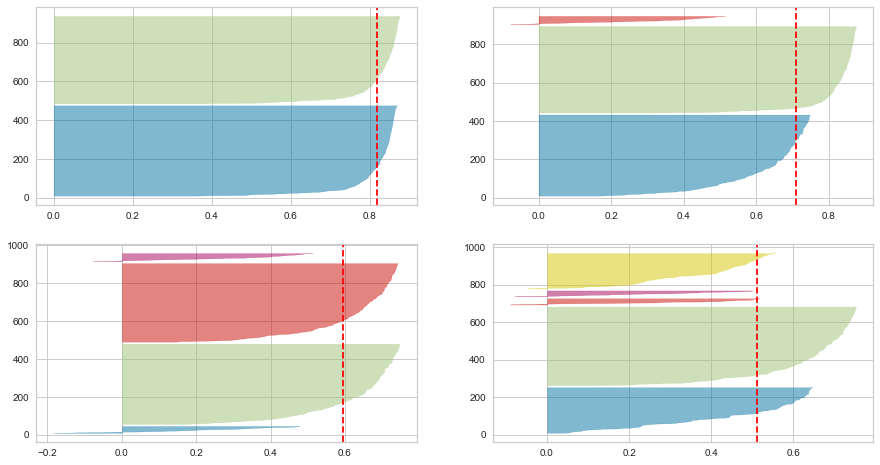

In [37]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data_scaled)

#### Criteria for DBSCAN

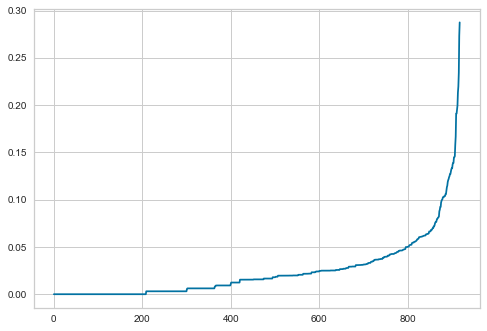

In [38]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(data_scaled)
distances, indices = nbrs.kneighbors(data_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

#### Comparing the cell types

In [39]:
#Hierarchical clustering, K-means clustering with cosine k-means, .....
kmeans_norm = KMeans(n_clusters=4).fit(data_scaled)
dbs_data = DBSCAN(eps=0.30, min_samples=2).fit(data_scaled)

silhouette_score1 = silhouette_score(data_scaled, hierarchical_clustering3[0],metric='euclidean')
silhouette_score2 = silhouette_score(data_scaled, kmeans_norm.labels_, metric='euclidean')
silhouette_score3 = silhouette_score(data_scaled, kmeans_norm.labels_, metric='cosine')
silhouette_score4 = silhouette_score(data_scaled, dbs_data.labels_)

davies_bouldin_score1 = davies_bouldin_score(data_scaled,hierarchical_clustering3[0])
davies_bouldin_score2 = davies_bouldin_score(data_scaled,kmeans_norm.labels_)
davies_bouldin_score3 = davies_bouldin_score(data_scaled,kmeans_norm.labels_)
davies_bouldin_score4 = davies_bouldin_score(data_scaled,dbs_data.labels_)

calinski_harabasz_score1 = calinski_harabasz_score(data_scaled,hierarchical_clustering3[0])
calinski_harabasz_score2 = calinski_harabasz_score(data_scaled,kmeans_norm.labels_)
calinski_harabasz_score3 = calinski_harabasz_score(data_scaled,kmeans_norm.labels_)
calinski_harabasz_score4 = calinski_harabasz_score(data_scaled,dbs_data.labels_)

clustering_results_df = {'Linkage Type': ['Agglomerative Hierarchical clustering(linkage = Average)','Kmeans','Cosine Based Kmeans','DBSCAN'],'Silhouette Score': [silhouette_score1,silhouette_score2,silhouette_score3,silhouette_score4], 'Davies Bouldin Score': [davies_bouldin_score1, davies_bouldin_score2, davies_bouldin_score3, davies_bouldin_score4],'Calinski Harabasz Score': [calinski_harabasz_score1, calinski_harabasz_score2, calinski_harabasz_score3, calinski_harabasz_score4]}  
df_of_results = pd.DataFrame(clustering_results_df)  
print(df_of_results.to_latex())


\begin{tabular}{llrrr}
\toprule
{} &                                       Linkage Type &  Silhouette Score &  Davies Bouldin Score &  Calinski Harabasz Score \\
\midrule
0 &  Agglomerative Hierarchical clustering(linkage ... &          0.693738 &              0.501952 &              3989.031643 \\
1 &                                             Kmeans &          0.596178 &              0.858600 &              4779.081595 \\
2 &                                Cosine Based Kmeans &          0.785458 &              0.858600 &              4779.081595 \\
3 &                                             DBSCAN &          0.819269 &              0.265808 &              8563.601078 \\
\bottomrule
\end{tabular}



### <a name="UseCaseBVisualization">3.4 Visualization of clusters for use case A</a> 
[Back to Table of Contents](#table)



In [6]:
import io
import sys
import folium
from PyQt5 import QtCore, QtGui, QtWidgets
from PyQt5.QtWebEngineWidgets import QWebEngineView 
from PyQt5.QtWebEngineWidgets import QWebEngineSettings as QWebSettings
from folium import IFrame
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import collections, numpy
from matplotlib import animation
from pyclustertend import hopkins
from scipy import stats
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import folium

class Window(QtWidgets.QMainWindow):
    def __init__(self,dataset):
        self._dataset = dataset
        self._df_including_cordinates = self._dataset.copy()
        self._dataset.drop('longitude', inplace=True, axis=1)
        self._dataset.drop('latitude', inplace=True, axis=1)
        self._dataset.drop('name', inplace=True, axis=1)
        self._dataset.drop('clubname', inplace=True, axis=1)
        super().__init__()
        self.initWindow()

    def initWindow(self):
        self.setWindowTitle(self.tr("Football Player Clusters"))
        self.setFixedSize(1500, 800)
        self.comboBox1 = QtWidgets.QComboBox(self)
        self.editField2 = QtWidgets.QLineEdit(self)
        self.editField3 = QtWidgets.QLineEdit(self)
        self.editField4 = QtWidgets.QLineEdit(self)
        self.label5 = QtWidgets.QLabel('red',self)
        self.label5.setHidden(True)
        self.m = folium.Map(location=[51.5074, 0.1278], zoom_start=6)
        self.buttonUI()

    def buttonUI(self):
        submitButton = QtWidgets.QPushButton(self.tr("Submit"))
        submitButton.clicked.connect(self.calculateClusterPressed)
        self.comboBox1.setFixedSize(120, 50)
        self.comboBox1.addItem("Premier League")
        self.comboBox1.addItem("La Liga")
        self.editField2.setFixedSize(120, 50)
        self.editField3.setFixedSize(120, 50)
        self.editField4.setFixedSize(120, 50)
        submitButton.move(20, 260)
        label1 = QtWidgets.QLabel(self)
        label1.setText("League:")
        label1.setFixedSize(120, 50)
        label2 = QtWidgets.QLabel(self)
        label2.setText("Goals:")
        label2.setFixedSize(120, 50)
        label3 = QtWidgets.QLabel(self)
        label3.setText("National Goals:")
        label3.setFixedSize(120, 50)
        label4 = QtWidgets.QLabel(self)
        label4.setText("Height:")
        label4.setFixedSize(120, 50)
        self.label5.setText("Data is an outlier")
        self.label5.setFixedSize(120, 50)
        self.label5.setStyleSheet("background-color: red")
        self.view = QWebEngineView()
        self.view.setContentsMargins(50, 50, 50, 50)
        central_widget = QtWidgets.QWidget()
        self.setCentralWidget(central_widget)
        lay = QtWidgets.QHBoxLayout(central_widget)
        button_container = QtWidgets.QWidget()
        vlay = QtWidgets.QVBoxLayout(button_container)
        vlay.setSpacing(20)
        vlay.addStretch()
        vlay.addWidget(label1)
        vlay.addWidget(self.comboBox1)
        vlay.addWidget(label2)
        vlay.addWidget(self.editField2)
        vlay.addWidget(label3)
        vlay.addWidget(self.editField3)
        vlay.addWidget(label4)
        vlay.addWidget(self.editField4)
        vlay.addWidget(submitButton)
        vlay.addWidget(self.label5)
        vlay.addStretch()
        lay.addWidget(button_container)
        lay.addWidget(self.view, stretch=1)
        data = io.BytesIO()
        self.m.save(data, close_file=False)
        self.view.setHtml(data.getvalue().decode())
    
    def calculateClusterPressed(self):
        current_league = str(self.comboBox1.currentText())
        if current_league == "Premier League":
            prem_value = 1.0
            la_liga = 0.0
        else:
            prem_value = 0.0
            la_liga = 1.0

        insertData = {'League_Premier League':prem_value, 'League_La Liga':la_liga,'goals':self.editField2.text(),
                       'nationalgoals':self.editField3.text(), 'height':self.editField4.text() }
        self._dataset = self._dataset.append(insertData, ignore_index=True)
        df1_football_players = football_players_df
        scaler = MinMaxScaler()
        data_scaled = pd.DataFrame(scaler.fit_transform(self._dataset), columns=self._dataset.columns)
        cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')  
        team_models = cluster.fit_predict(data_scaled)
        hierarchical_clustering = pd.DataFrame(team_models)
        dct_of_colour =  {0:"red", 1:"green",2:"blue",3:"orange"}
        new_item_cluster = team_models[-1]
        if np.count_nonzero(team_models == new_item_cluster) == 1:
            self.label5.setHidden(False)
        else:
            self.label5.setHidden(True)
            i = 0
            for index, row in self._df_including_cordinates.iterrows():
                if hierarchical_clustering[0][i] == team_models[-1]:
                    html="""
                    <h1>""" + str(row['name']) + """'s data'</h1><br>
                    <b> Name: </b> """ + str(row['name']) + """ <br>
                    <b> League: </b> """ + current_league + """ <br>
                    <b> Club Name: </b> """ + str(row['clubname']) + """ <br>
                    <b> Height: </b> """ + str(row['height']) + """ <br>
                    <b> Number Of Club Goals Scored: </b> """ + str(row['goals']) + """ <br>
                    <b> Number Of International Goals: </b> """ + str(row['nationalgoals']) + """ <br>
                    """

                    frame = IFrame(html=html, width=500, height=300)
                    pop_text = folium.Popup(frame, max_width=2650)
                    folium.Marker(
                    [row['latitude'], row['longitude']], 
                    popup = pop_text, 
                    icon=folium.Icon(color = dct_of_colour[hierarchical_clustering[0][i]], icon="fa-futbol"),
                    ).add_to(self.m)
                i += 1
                self.m
                data = io.BytesIO()
                self.m.save(data, close_file=False)
                self.view.setHtml(data.getvalue().decode())
        
if __name__ == "__main__":
    football_players_df = pd.read_excel("football_players.xlsx", sheet_name="Sheet1_Football_players")
    football_players_df = football_players_df.drop(labels=[573], axis=0)
    df1_football_players = edit_data_frame_with_columns(['name','clubname','latitude','longitude','league', 'goals', 'nationalgoals', 'height'],football_players_df)
    App = QtCore.QCoreApplication.instance()
    if App is None:
        App = QtWidgets.QApplication(sys.argv)
    window = Window(df1_football_players)
    window.show()
    sys.exit(App.exec())


SystemExit: 0

/Users/colmclery/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)



### <a name="UseCaseBTimeExperiment">3.5 Experimenting Time To Load Cluster items</a> 
[Back to Table of Contents](#table)

In [40]:
import time
num_clusters = 4
affin = 'euclidean'
link = 'complete'
football_players_df = pd.read_excel("football_players.xlsx", sheet_name="Sheet1_Football_players")
df1_football_players = edit_data_frame_with_columns(['name','clubname','latitude','longitude','league', 'goals', 'nationalgoals', 'height'],football_players_df)
df1_football_players_copy = df1_football_players.copy()
df1_football_players.drop('longitude', inplace=True, axis=1)
df1_football_players.drop('latitude', inplace=True, axis=1)
df1_football_players.drop('name', inplace=True, axis=1)
df1_football_players.drop('clubname', inplace=True, axis=1)
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(df1_football_players), columns=df1_football_players.columns)
cluster = AgglomerativeClustering(n_clusters=num_clusters, affinity=affin, linkage=link) 
team_models = cluster.fit_predict(data_scaled)
hierarchical_clustering = pd.DataFrame(team_models)
data_scaled.insert((data_scaled.shape[1]),'agglomerative',hierarchical_clustering)
dct_of_colour =  {0:"red", 1:"green",2:"blue",3:"orange"}
times_dct = {"Cluster ID":[],"Number Of Vehicles":[],"Time To Load":[],}
m = folium.Map(location=[51.5074, 0.1278], zoom_start=6)
cluster_id = 0
for cluster in range(num_clusters):
    i = 0
    t1 = time.time()
    count_per_cluster = 0
    for index, row in df1_football_players_copy.iterrows():
        if team_models[i] == cluster_id:
            count_per_cluster += 1
            html="""
                    <h1>""" + str(row['name']) + """'s data'</h1><br>
                    <p>
                    </p>
                    <b> Name: </b> """ + str(row['name']) + """ <br>
                    <b> Club Name: </b> """ + str(row['clubname']) + """ <br>
                    <b> Height: </b> """ + str(row['height']) + """ <br>
                    <b> Number Of Club Goals Scored: </b> """ + str(row['goals']) + """ <br>
                    <b> Number Of International Goals: </b> """ + str(row['nationalgoals']) + """ <br>
                    """
            frame = IFrame(html=html, width=500, height=300)
            pop_text = folium.Popup(frame, max_width=2650)
            folium.Marker(
            [row['latitude'], row['longitude']], 
            popup = pop_text, 
            icon=folium.Icon(color = dct_of_colour[hierarchical_clustering[0][i]], icon="fa-futbol"),
            ).add_to(m)
            m
        i += 1
    t2 = time.time()
    times_dct["Time To Load"].append(t2 - t1)
    cluster_id+=1
    times_dct["Number Of Vehicles"].append(count_per_cluster)
    times_dct["Cluster ID"].append(cluster_id)
df = pd.DataFrame(times_dct)
print(df.to_latex())
data = io.BytesIO()
m.save(data, close_file=False)
m





\begin{tabular}{lrrr}
\toprule
{} &  Cluster ID &  Number Of Vehicles &  Time To Load \\
\midrule
0 &           1 &                 453 &      0.442300 \\
1 &           2 &                 452 &      0.407015 \\
2 &           3 &                   1 &      0.071500 \\
3 &           4 &                  14 &      0.073685 \\
\bottomrule
\end{tabular}



## <a name="UseCaseC">4. Use Case C: Find Information about Football Positions </a>

### <a name="UseCaseCFeatureSelection">4.1. FeatureSelection</a> 
[Back to Table of Contents](#table)

In [41]:
football_players_df = pd.read_excel("football_players.xlsx", sheet_name="Sheet1_Football_players")
print(find_best_features(['num_clubs','positionlabel','height','nationalgoals','nationalcaps','goals','clubcaps'],4,football_players_df,False))

(['positionlabel', 'goals', 'nationalgoals', 'height'], 'ward', 6, 0.8074878748975318)


In [42]:
football_players_df = pd.read_excel("football_players.xlsx", sheet_name="Sheet1_Football_players")
football_players_df = edit_data_frame_with_columns(['positionlabel', 'goals', 'nationalgoals', 'height'],football_players_df)
#Removing the outlier row 569
football_players_df = football_players_df.drop(labels=[573], axis=0)
df1_football_players = football_players_df
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(football_players_df), columns=football_players_df.columns)
data_scaled.head()

height  nationalgoals     goals  \
0  0.627451       0.015385  0.003086   
1  0.549020       0.000000  0.033951   
2  0.588235       0.046154  0.123457   
3  0.529412       0.046154  0.009259   
4  0.549020       0.000000  0.003086   

   Position_Goalkeeper (association football)  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   

   Position_Defender (association football)  Position_Midfielder  \
0                                       1.0                  0.0   
1                                       0.0                  1.0   
2                                       0.0                  0.0   
3                                       1.0                  0.0   
4                                       0.0                  1.0   

   Position_Forward (association football)  
0                                      0.0  
1                                      0.0  
2                                      1.0  
3                                      0.0  
4                                      0.0

##### Identifying and removing outliers

In [43]:
data_scaled[(np.abs(stats.zscore(data_scaled)) < 3).all(axis=1)]

height  nationalgoals     goals  \
0    0.627451       0.015385  0.003086   
1    0.549020       0.000000  0.033951   
2    0.588235       0.046154  0.123457   
3    0.529412       0.046154  0.009259   
4    0.549020       0.000000  0.003086   
..        ...            ...       ...   
911  0.411765       0.061538  0.089506   
912  0.490196       0.015385  0.033951   
913  0.411765       0.092308  0.018519   
915  0.588235       0.000000  0.015432   
918  0.352941       0.000000  0.070988   

     Position_Goalkeeper (association football)  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   
..                                          ...   
911                                         0.0   
912                                         0.0   
913                                         0.0   
915                                         0.0   
918                                         0.0   

     Position_Defender (association football)  Position_Midfielder  \
0                                         1.0                  0.0   
1                                         0.0                  1.0   
2                                         0.0                  0.0   
3                                         1.0                  0.0   
4                                         0.0                  1.0   
..                                        ...                  ...   
911                                       0.0                  1.0   
912                                       0.0                  1.0   
913                                       0.0                  1.0   
915                                       1.0                  0.0   
918                                       0.0                  1.0   

     Position_Forward (association football)  
0                                        0.0  
1                                        0.0  
2                                        1.0  
3                                        0.0  
4                                        0.0  
..                                       ...  
911                                      0.0  
912                                      0.0  
913                                      0.0  
915                                      0.0  
918                                      0.0  

[792 rows x 7 columns]

##### Testing to determine the clustering tendency of a data set.

In [44]:
hopkins(df1_football_players,len(df1_football_players))

0.08197820548494787

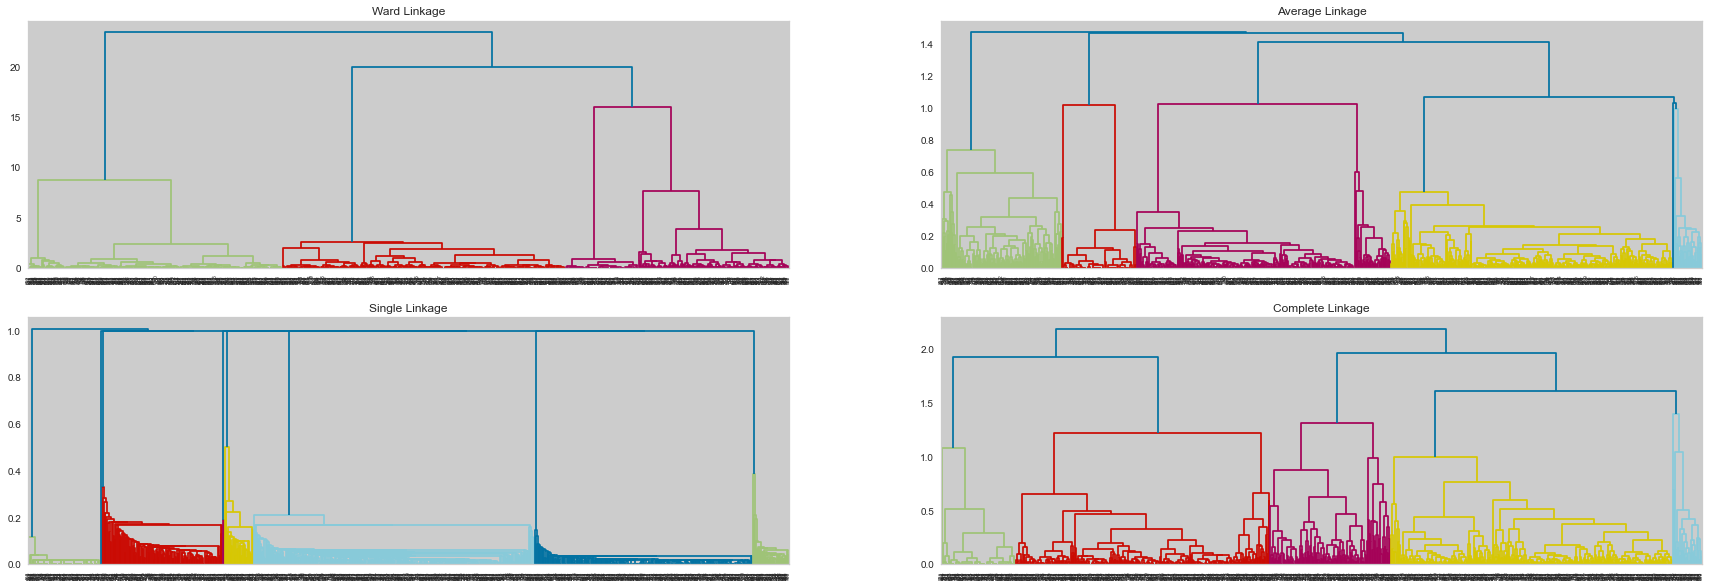

In [45]:
import scipy.cluster.hierarchy as shc
rows = 2
columns = 2
figure = plt.figure(figsize=(30, 10))  
figure.add_subplot(rows, columns, 1)
plt.title("Ward Linkage")  
shc.dendrogram(shc.linkage(data_scaled, method='ward'))
figure.add_subplot(rows, columns, 2)
plt.title("Average Linkage")  
shc.dendrogram(shc.linkage(data_scaled, method='average'))
figure.add_subplot(rows, columns, 3)
plt.title("Single Linkage")  
shc.dendrogram(shc.linkage(data_scaled, method='single'))
figure.add_subplot(rows, columns, 4)
plt.title("Complete Linkage")  
shc.dendrogram(shc.linkage(data_scaled, method='complete'))
figure.savefig('DendogramsFotoPlayC1.png', dpi=300, bbox_inches='tight')


## Applying Hierarchical clustering for the clusters

In [46]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=9, affinity='euclidean', linkage='ward')  
team_models = cluster.fit_predict(data_scaled)

### <a name="UseCaseCClusterUnderstanding">4.2 Feature Selection and Understanding Clusters</a> 
[Back to Table of Contents](#table)

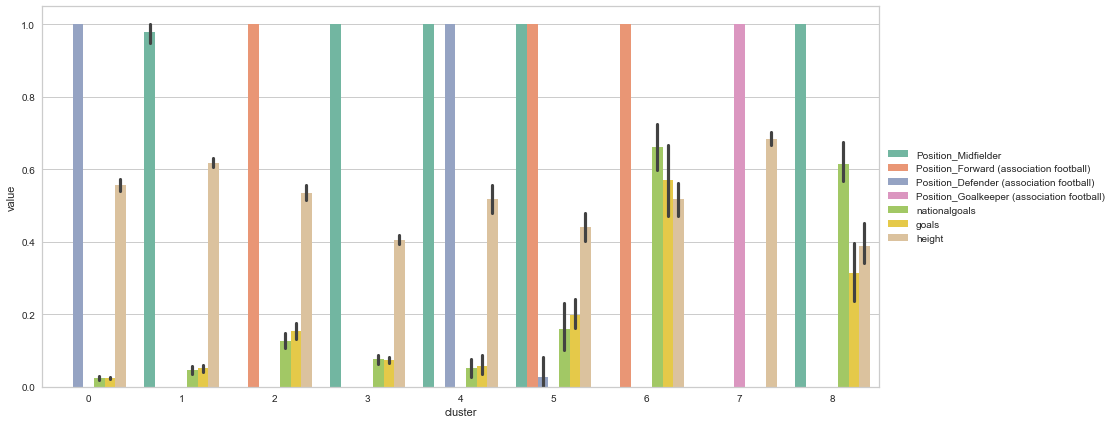

In [47]:
cluster = AgglomerativeClustering(n_clusters=9, affinity='euclidean', linkage='ward')  
team_models = cluster.fit_predict(data_scaled)
minMaxscaler = MinMaxScaler()
scaledDataFrame = pd.DataFrame(minMaxscaler.fit_transform(df1_football_players))
scaledDataFrame.columns = df1_football_players.columns
scaledDataFrame['cluster'] = cluster.labels_
meansDataFrame = scaledDataFrame.groupby('cluster').mean().reset_index()
variablesDeviations = pd.DataFrame(columns=['Vars', 'Deviation'])
i = 0
while i < len(meansDataFrame.columns[1:]):
    variablesDeviations.loc[len(variablesDeviations), :] = [meansDataFrame.columns[1:][i], np.std(meansDataFrame[meansDataFrame.columns[1:][i]])]
    i+=1
includedColumns = list(variablesDeviations.sort_values('Deviation', ascending=False).head(10).Vars.values) + ['cluster']
finalData = scaledDataFrame[includedColumns].melt(id_vars='cluster')
figure, axix = plt.subplots(figsize=(15, 7))
sns.barplot(x='cluster', y='value', hue='variable', data=finalData, palette='Set2')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("clustersFromFootPlayersC.jpg", dpi=300)

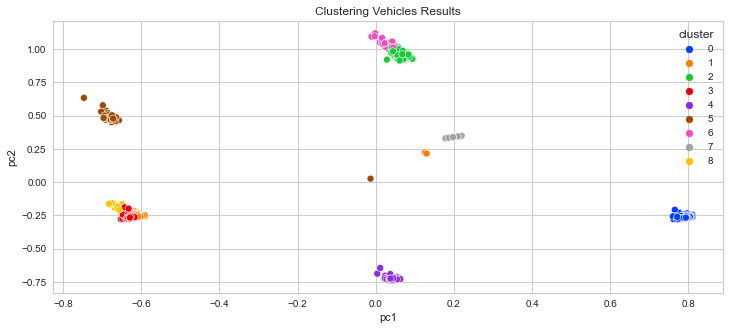

In [48]:
from sklearn.decomposition import PCA
fig, (sub1) = plt.subplots(1, figsize=(12, 5))
pca_vehicle_data = PCA(n_components=2)
principalComponents_vehicles = pca_vehicle_data.fit_transform(data_scaled)
sns.scatterplot(x=principalComponents_vehicles[:,0], y=principalComponents_vehicles[:,1], hue=team_models, palette='bright',ax=sub1);
sub1.set(xlabel="pc1", ylabel="pc2", title="Clustering Vehicles Results")
sub1.legend(title='cluster');
fig.savefig('PCAFootPlayersC1.png', dpi=300, bbox_inches='tight')

##### Creating Clusters Rule Table

In [49]:
dct_of_clusters = {"cluster numbers":[1,2,3,4,5,6,7,8,9],"cluster descriptions": ["Defenders only",
 "Midfielders that are taller than 1.8149999976158142",
 "Forwards with less than 32 goals",
  "Midfielders that are smaller than 1.8149999976158142",
 "Players that can play as midfielders and Defenders",
 "Players that can play as midfielders and forwards and that are smaller than 1.8149999976158142",
"Forwards with more than 32 goals",
 "Goalkeepers only","Midfielders that have scored a lot of goals for their clubs and countries."]}
df_of_results = pd.DataFrame(dct_of_clusters)  
print(df_of_results.to_latex())

\begin{tabular}{lrl}
\toprule
{} &  cluster numbers &                               cluster descriptions \\
\midrule
0 &                1 &                                     Defenders only \\
1 &                2 &  Midfielders that are taller than 1.81499999761... \\
2 &                3 &                   Forwards with less than 32 goals \\
3 &                4 &  Midfielders that are smaller than 1.8149999976... \\
4 &                5 &  Players that can play as midfielders and Defen... \\
5 &                6 &  Players that can play as midfielders and forwa... \\
6 &                7 &                   Forwards with more than 32 goals \\
7 &                8 &                                   Goalkeepers only \\
8 &                9 &  Midfielders that have scored a lot of goals fo... \\
\bottomrule
\end{tabular}



### <a name="UseCaseCSilhoutteResults">4.3 Analysing Cluster Results with Different linkage criteria and number of clusters</a> 
[Back to Table of Contents](#table)

In [50]:
sil_scores = []
dav_scores = []
calin_scores = []
n_clusters = []
for i in range(2,20):
    cluster1 = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')  
    team_models1 = cluster1.fit_predict(data_scaled)
    hierarchical_clustering = pd.DataFrame(team_models1)
    dav_scores.append(davies_bouldin_score(data_scaled,hierarchical_clustering[0]))
    sil_scores.append(silhouette_score(data_scaled,hierarchical_clustering[0],metric='euclidean'))
    calin_scores.append(calinski_harabasz_score(data_scaled,hierarchical_clustering[0]))
    n_clusters.append(i) 
hierarchicial_clustering_results_df = {'Num Clusters': n_clusters,'Silhouette Score': sil_scores, 'Davies Bouldin Score': dav_scores,'Calinski Harabasz Score': calin_scores}  
df_measures = pd.DataFrame(hierarchicial_clustering_results_df)  
print(df_measures.to_latex())


\begin{tabular}{lrrrr}
\toprule
{} &  Num Clusters &  Silhouette Score &  Davies Bouldin Score &  Calinski Harabasz Score \\
\midrule
0  &             2 &          0.472342 &              0.904849 &               578.808968 \\
1  &             3 &          0.628858 &              0.836859 &               921.427527 \\
2  &             4 &          0.736008 &              0.467901 &              1697.962590 \\
3  &             5 &          0.759560 &              0.415169 &              2082.706448 \\
4  &             6 &          0.782651 &              0.377420 &              2984.283302 \\
5  &             7 &          0.770675 &              0.431721 &              3084.784255 \\
6  &             8 &          0.594135 &              0.626041 &              2953.858640 \\
7  &             9 &          0.608747 &              0.593209 &              2884.731278 \\
8  &            10 &          0.504625 &              0.655527 &              2871.814384 \\
9  &            11 &         

In [51]:
cluster1 = AgglomerativeClustering(n_clusters=9, affinity='euclidean', linkage='ward')  
team_models1 = cluster1.fit_predict(data_scaled)
hierarchical_clustering1 = pd.DataFrame(team_models1)
davies_bouldin_score1 = davies_bouldin_score(data_scaled,hierarchical_clustering1[0])
silhouette_score1 = silhouette_score(data_scaled,hierarchical_clustering1[0],metric='euclidean')
calinski_harabasz_score1 = calinski_harabasz_score(data_scaled,hierarchical_clustering1[0])

cluster2 = AgglomerativeClustering(n_clusters=9, affinity='euclidean', linkage='average')  
team_models2 = cluster2.fit_predict(data_scaled)
hierarchical_clustering2 = pd.DataFrame(team_models2)
davies_bouldin_score2 = davies_bouldin_score(data_scaled,hierarchical_clustering2[0])
silhouette_score2 = silhouette_score(data_scaled,hierarchical_clustering2[0],metric='euclidean')
calinski_harabasz_score2 = calinski_harabasz_score(data_scaled,hierarchical_clustering2[0])

cluster3 = AgglomerativeClustering(n_clusters=9, affinity='euclidean', linkage='complete')  
team_models3 = cluster3.fit_predict(data_scaled)
hierarchical_clustering3 = pd.DataFrame(team_models3)
davies_bouldin_score3 = davies_bouldin_score(data_scaled,hierarchical_clustering3[0])
silhouette_score3 = silhouette_score(data_scaled,hierarchical_clustering3[0],metric='euclidean')
calinski_harabasz_score3 = calinski_harabasz_score(data_scaled,hierarchical_clustering3[0])

cluster4 = AgglomerativeClustering(n_clusters=9, affinity='euclidean', linkage='single') 
team_models4 = cluster4.fit_predict(data_scaled)
hierarchical_clustering4 = pd.DataFrame(team_models4)
davies_bouldin_score4 = davies_bouldin_score(data_scaled,hierarchical_clustering4[0])
silhouette_score4 = silhouette_score(data_scaled,hierarchical_clustering4[0],metric='euclidean')
calinski_harabasz_score4 = calinski_harabasz_score(data_scaled,hierarchical_clustering4[0])

hierarchicial_clustering_results_df = {'Linkage Type': ['Ward','Average','Complete','Single'],'Silhouette Score': [silhouette_score1,silhouette_score2,silhouette_score3,silhouette_score4], 'Davies Bouldin Score': [davies_bouldin_score1, davies_bouldin_score2, davies_bouldin_score3, davies_bouldin_score4],'Calinski Harabasz Score': [calinski_harabasz_score1, calinski_harabasz_score2, calinski_harabasz_score3, calinski_harabasz_score4]}  
df_measures = pd.DataFrame(hierarchicial_clustering_results_df)  
print(df_measures.to_latex())


\begin{tabular}{llrrr}
\toprule
{} & Linkage Type &  Silhouette Score &  Davies Bouldin Score &  Calinski Harabasz Score \\
\midrule
0 &         Ward &          0.608747 &              0.593209 &              2884.731278 \\
1 &      Average &          0.778232 &              0.319344 &              2071.513259 \\
2 &     Complete &          0.758634 &              0.518226 &              2570.112382 \\
3 &       Single &          0.778232 &              0.319344 &              2071.513259 \\
\bottomrule
\end{tabular}



#### Determining the number of clusters for K-means Algorithm using Silhouette Visualizer

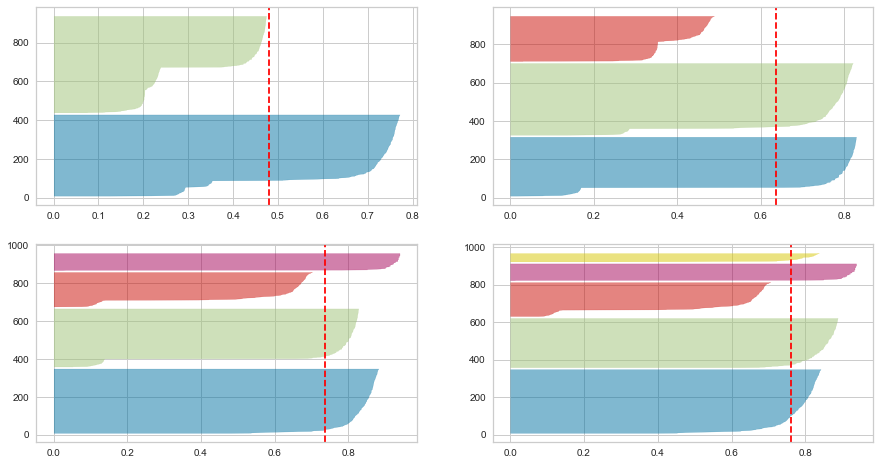

In [52]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data_scaled)

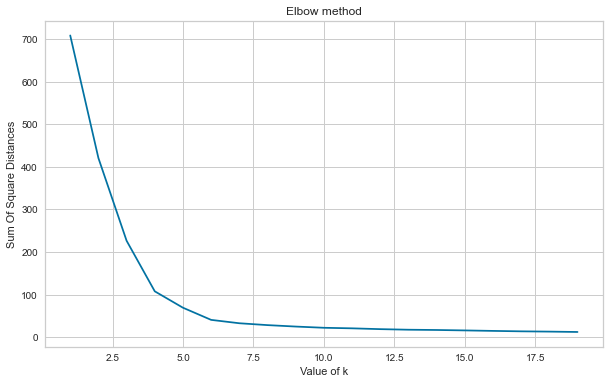

In [53]:
#Using Elbow Method when num clusters > 5
sum_of_squared_distances = []
cluster_range = range(1,20)
for cluster_num in cluster_range:
    kModel = KMeans(n_clusters=cluster_num)
    kModel.fit(data_scaled)
    sum_of_squared_distances.append(kModel.inertia_)
plt.figure(figsize=(10,6))
plt.plot(cluster_range, sum_of_squared_distances, 'bx-')
plt.xlabel('Value of k')
plt.ylabel('Sum Of Square Distances')
plt.title('Elbow method')
plt.show()

#### Criteria for DBSCAN

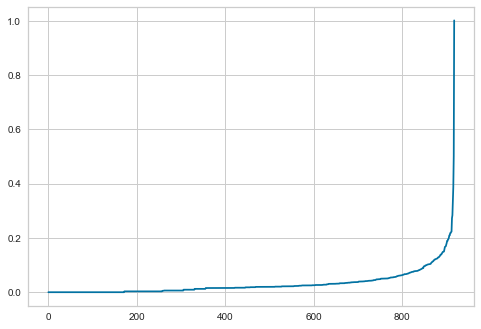

In [54]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(data_scaled)
distances, indices = nbrs.kneighbors(data_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

#### Comparing the cell types

In [55]:
#Hierarchical clustering, K-means clustering with cosine k-means, .....
kmeans_norm = KMeans(n_clusters=4).fit(data_scaled)
dbs_data = DBSCAN(eps=0.20, min_samples=2).fit(data_scaled)

silhouette_score1 = silhouette_score(data_scaled, hierarchical_clustering1[0],metric='euclidean')
silhouette_score2 = silhouette_score(data_scaled, kmeans_norm.labels_, metric='euclidean')
silhouette_score3 = silhouette_score(data_scaled, kmeans_norm.labels_, metric='cosine')
silhouette_score4 = silhouette_score(data_scaled, dbs_data.labels_)

davies_bouldin_score1 = davies_bouldin_score(data_scaled,hierarchical_clustering1[0])
davies_bouldin_score2 = davies_bouldin_score(data_scaled,kmeans_norm.labels_)
davies_bouldin_score3 = davies_bouldin_score(data_scaled,kmeans_norm.labels_)
davies_bouldin_score4 = davies_bouldin_score(data_scaled,dbs_data.labels_)

calinski_harabasz_score1 = calinski_harabasz_score(data_scaled,hierarchical_clustering1[0])
calinski_harabasz_score2 = calinski_harabasz_score(data_scaled,kmeans_norm.labels_)
calinski_harabasz_score3 = calinski_harabasz_score(data_scaled,kmeans_norm.labels_)
calinski_harabasz_score4 = calinski_harabasz_score(data_scaled,dbs_data.labels_)

clustering_results_df = {'Linkage Type': ['Agglomerative Hierarchical clustering(linkage = Average)','Kmeans','Cosine Based Kmeans','DBSCAN'],'Silhouette Score': [silhouette_score1,silhouette_score2,silhouette_score3,silhouette_score4], 'Davies Bouldin Score': [davies_bouldin_score1, davies_bouldin_score2, davies_bouldin_score3, davies_bouldin_score4],'Calinski Harabasz Score': [calinski_harabasz_score1, calinski_harabasz_score2, calinski_harabasz_score3, calinski_harabasz_score4]}  
df_of_results = pd.DataFrame(clustering_results_df)  
print(df_of_results.to_latex())

\begin{tabular}{llrrr}
\toprule
{} &                                       Linkage Type &  Silhouette Score &  Davies Bouldin Score &  Calinski Harabasz Score \\
\midrule
0 &  Agglomerative Hierarchical clustering(linkage ... &          0.608747 &              0.593209 &              2884.731278 \\
1 &                                             Kmeans &          0.735532 &              0.472194 &              1699.034588 \\
2 &                                Cosine Based Kmeans &          0.867591 &              0.472194 &              1699.034588 \\
3 &                                             DBSCAN &          0.774986 &              0.964203 &              2090.277294 \\
\bottomrule
\end{tabular}



### <a name="UseCaseCVisualization">4.4 Visualization of clusters for use case C</a> 
[Back to Table of Contents](#table)



In [7]:
import io
import sys
import folium
from PyQt5 import QtCore, QtGui, QtWidgets
from PyQt5.QtWebEngineWidgets import QWebEngineView 
from PyQt5.QtWebEngineWidgets import QWebEngineSettings as QWebSettings
from folium import IFrame
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import collections, numpy
from matplotlib import animation
from pyclustertend import hopkins
from scipy import stats
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import folium

class Window(QtWidgets.QMainWindow):
    def __init__(self,dataset):
        self._dataset = dataset
        self._df_including_cordinates = self._dataset.copy()
        self._dataset.drop('longitude', inplace=True, axis=1)
        self._dataset.drop('latitude', inplace=True, axis=1)
        self._dataset.drop('name', inplace=True, axis=1)
        self._dataset.drop('clubname', inplace=True, axis=1)
        super().__init__()
        self.initWindow()

    def initWindow(self):
        self.setWindowTitle(self.tr("Football Player Clusters"))
        self.setFixedSize(1500, 800)
        self.checkBox1 = QtWidgets.QCheckBox("GKs",self)
        self.checkBox2 = QtWidgets.QCheckBox("DFs",self)
        self.checkBox3 = QtWidgets.QCheckBox("MFs",self)
        self.checkBox4 = QtWidgets.QCheckBox("FWs",self)
        self.editField2 = QtWidgets.QLineEdit(self)
        self.editField3 = QtWidgets.QLineEdit(self)
        self.editField4 = QtWidgets.QLineEdit(self)
        self.label5 = QtWidgets.QLabel('red',self)
        self.label5.setHidden(True)
        self.m = folium.Map(location=[51.5074, 0.1278], zoom_start=6)
        self.buttonUI()

    def buttonUI(self):
        submitButton = QtWidgets.QPushButton(self.tr("Submit"))
        submitButton.clicked.connect(self.calculateClusterPressed)
        self.editField2.setFixedSize(120, 50)
        self.editField3.setFixedSize(120, 50)
        self.editField4.setFixedSize(120, 50)
        submitButton.move(20, 260)
        label1 = QtWidgets.QLabel(self)
        label1.setText("Position:")
        label1.setFixedSize(120, 50)
        label2 = QtWidgets.QLabel(self)
        label2.setText("Goals:")
        label2.setFixedSize(120, 50)
        label3 = QtWidgets.QLabel(self)
        label3.setText("National Goals:")
        label3.setFixedSize(120, 50)
        label4 = QtWidgets.QLabel(self)
        label4.setText("Height:")
        label4.setFixedSize(120, 50)
        self.label5.setText("Data is an outlier")
        self.label5.setFixedSize(120, 50)
        self.label5.setStyleSheet("background-color: red")
        self.view = QWebEngineView()
        self.view.setContentsMargins(50, 50, 50, 50)
        central_widget = QtWidgets.QWidget()
        self.setCentralWidget(central_widget)
        lay = QtWidgets.QHBoxLayout(central_widget)
        button_container = QtWidgets.QWidget()
        vlay = QtWidgets.QVBoxLayout(button_container)
        vlay.setSpacing(20)
        vlay.addStretch()
        vlay.addWidget(label1)
        vlay.addWidget(self.checkBox1)
        vlay.addWidget(self.checkBox2)
        vlay.addWidget(self.checkBox3)
        vlay.addWidget(self.checkBox4)
        vlay.addWidget(label2)
        vlay.addWidget(self.editField2)
        vlay.addWidget(label3)
        vlay.addWidget(self.editField3)
        vlay.addWidget(label4)
        vlay.addWidget(self.editField4)
        vlay.addWidget(submitButton)
        vlay.addWidget(self.label5)
        vlay.addStretch()
        lay.addWidget(button_container)
        lay.addWidget(self.view, stretch=1)
        data = io.BytesIO()
        self.m.save(data, close_file=False)
        self.view.setHtml(data.getvalue().decode())
    
    def calculateClusterPressed(self):
        position_labels = ""
        if self.checkBox1.isChecked():
            gk_value = 1
            position_labels += "Goalkeeper "
        else:
            gk_value = 0
            
        if self.checkBox2.isChecked():
            df_value = 1
            position_labels += "Defender "
            
        else:
            df_value = 0
        
        if self.checkBox3.isChecked():
            mf_value = 1
            position_labels += "Midfielder "
        else:
            mf_value = 0
        
        if self.checkBox4.isChecked():
            fw_value = 1
            position_labels += "Forward "
        else:
            fw_value = 0
        insertData = {'Position_Goalkeeper (association football)':gk_value, 'Position_Defender (association football)':df_value,'Position_Midfielder':mf_value, 'Position_Forward (association football)':fw_value,'goals':self.editField2.text(),
                       'nationalgoals':self.editField3.text(), 'height':self.editField4.text() }
        self._dataset = self._dataset.append(insertData, ignore_index=True)
        df1_football_players = football_players_df
        scaler = MinMaxScaler()
        data_scaled = pd.DataFrame(scaler.fit_transform(self._dataset), columns=self._dataset.columns)
        cluster = AgglomerativeClustering(n_clusters=9, affinity='euclidean', linkage='ward')  
        team_models = cluster.fit_predict(data_scaled)
        hierarchical_clustering = pd.DataFrame(team_models)
        dct_of_colour =  {0:"red", 1:"green",2:"blue",3:"orange",4:"purple",5:"grey",6:"yellow",7:"black",8:"brown"}
        new_item_cluster = team_models[-1]
        if np.count_nonzero(team_models == new_item_cluster) == 1:
            self.label5.setHidden(False)
        else:
            self.label5.setHidden(True)
            i = 0
            for index, row in self._df_including_cordinates.iterrows():                
                if hierarchical_clustering[0][i] == team_models[-1]:
                    html="""
                    <h1>""" + str(row['name']) + """'s data'</h1><br>
                    
                    <b> Name: </b> """ + str(row['name']) + """ <br>
                    <b> Position(s): </b> """ + position_labels + """ <br>
                    <b> Club Name: </b> """ + str(row['clubname']) + """ <br>
                    <b> Height: </b> """ + str(row['height']) + """ <br>
                    <b> Number Of Club Goals Scored: </b> """ + str(row['goals']) + """ <br>
                    <b> Number Of International Goals: </b> """ + str(row['nationalgoals']) + """ <br>
                    """

                    frame = IFrame(html=html, width=500, height=300)
                    pop_text = folium.Popup(frame, max_width=2650)
                    folium.Marker(
                    [row['latitude'], row['longitude']], 
                    popup = pop_text, 
                    icon=folium.Icon(color = dct_of_colour[hierarchical_clustering[0][i]], icon="fa-futbol"),
                    ).add_to(self.m)
                i += 1
                self.m
                data = io.BytesIO()
                self.m.save(data, close_file=False)
                self.view.setHtml(data.getvalue().decode())
        
        
if __name__ == "__main__":
    football_players_df = pd.read_excel("football_players.xlsx", sheet_name="Sheet1_Football_players")
    football_players_df = football_players_df.drop(labels=[573], axis=0)
    df1_football_players = edit_data_frame_with_columns(['name','clubname','latitude','longitude','positionlabel', 'goals', 'nationalgoals', 'height'],football_players_df)
    App = QtCore.QCoreApplication.instance()
    if App is None:
        App = QtWidgets.QApplication(sys.argv)
    window = Window(df1_football_players)
    window.show()
    sys.exit(App.exec())


SystemExit: 0

/Users/colmclery/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)



### <a name="UseCaseCTimeExperiment">4.5 Experimenting Time To Load Cluster items</a> 
[Back to Table of Contents](#table)

In [56]:
import time
num_clusters = 9
affin = 'euclidean'
link = 'ward'
football_players_df = pd.read_excel("football_players.xlsx", sheet_name="Sheet1_Football_players")
df1_football_players = edit_data_frame_with_columns(['name','clubname','latitude','longitude','positionlabel', 'goals', 'nationalgoals', 'height'],football_players_df)
df1_football_players_copy = df1_football_players.copy()
df1_football_players.drop('longitude', inplace=True, axis=1)
df1_football_players.drop('latitude', inplace=True, axis=1)
df1_football_players.drop('name', inplace=True, axis=1)
df1_football_players.drop('clubname', inplace=True, axis=1)
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(df1_football_players), columns=df1_football_players.columns)
cluster = AgglomerativeClustering(n_clusters=num_clusters, affinity=affin, linkage=link) 
team_models = cluster.fit_predict(data_scaled)
hierarchical_clustering = pd.DataFrame(team_models)
data_scaled.insert((data_scaled.shape[1]),'agglomerative',hierarchical_clustering)
dct_of_colour =  {0:"red", 1:"green",2:"blue",3:"orange",4:"purple",5:"grey",6:"yellow",7:"black",8:"brown"}
times_dct = {"Cluster ID":[],"Number Of Vehicles":[],"Time To Load":[],}
m = folium.Map(location=[51.5074, 0.1278], zoom_start=6)
cluster_id = 0
for cluster in range(num_clusters):
    i = 0
    t1 = time.time()
    count_per_cluster = 0
    for index, row in df1_football_players_copy.iterrows():
        if team_models[i] == cluster_id:
            count_per_cluster += 1
            html="""
                    <h1>""" + str(row['name']) + """'s data'</h1><br>
                    <p>
                    </p>
                    <b> Name: </b> """ + str(row['name']) + """ <br>
                    <b> Club Name: </b> """ + str(row['clubname']) + """ <br>
                    <b> Height: </b> """ + str(row['height']) + """ <br>
                    <b> Number Of Club Goals Scored: </b> """ + str(row['goals']) + """ <br>
                    <b> Number Of International Goals: </b> """ + str(row['nationalgoals']) + """ <br>
                    """
            frame = IFrame(html=html, width=500, height=300)
            pop_text = folium.Popup(frame, max_width=2650)
            folium.Marker(
            [row['latitude'], row['longitude']], 
            popup = pop_text, 
            icon=folium.Icon(color = dct_of_colour[hierarchical_clustering[0][i]], icon="fa-futbol"),
            ).add_to(m)
        i += 1
    t2 = time.time()
    times_dct["Time To Load"].append(t2 - t1)
    cluster_id+=1
    times_dct["Number Of Vehicles"].append(count_per_cluster)
    times_dct["Cluster ID"].append(cluster_id)
df = pd.DataFrame(times_dct)
print(df.to_latex())
data = io.BytesIO()
m.save(data, close_file=False)
m





<ipython-input-56-7f10558d9289>:44: UserWarning: color argument of Icon should be one of: {'pink', 'lightred', 'black', 'lightgray', 'darkred', 'beige', 'blue', 'darkpurple', 'purple', 'darkblue', 'gray', 'darkgreen', 'white', 'lightgreen', 'orange', 'red', 'green', 'lightblue', 'cadetblue'}.
  icon=folium.Icon(color = dct_of_colour[hierarchical_clustering[0][i]], icon="fa-futbol"),


\begin{tabular}{lrrr}
\toprule
{} &  Cluster ID &  Number Of Vehicles &  Time To Load \\
\midrule
0 &           1 &                 257 &      0.315514 \\
1 &           2 &                  85 &      0.162574 \\
2 &           3 &                 128 &      0.194851 \\
3 &           4 &                 126 &      0.165693 \\
4 &           5 &                  44 &      0.093038 \\
5 &           6 &                  36 &      0.086720 \\
6 &           7 &                  19 &      0.070252 \\
7 &           8 &                  88 &      0.124223 \\
8 &           9 &                 137 &      0.173288 \\
\bottomrule
\end{tabular}

